# Goals and Project Structure



# Setting up the Project



### Mount Drive

In [ ]:
#

### Import Libraries

In [ ]:
pip install --upgrade numba ydata-profiling visions

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from ydata_profiling import ProfileReport

### Load Dataset

In [ ]:
url = '/content/drive/MyDrive/Data_Science_Projects/Loan Default/Loan_default.csv'
df = pd.read_csv(url)
df_copy = df.copy()
# quick glance at the data and ensure it is loaded properly
df.head()

# Inspecting the Data

### Shape

In [5]:
shape = df.shape
print(f'The dataset has {shape[0]} rows and {shape[1]} columns.')

The dataset has 255347 rows and 18 columns.


### Data Types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

## Missing Values

In [7]:
missing_vals = df.isna().sum()

if missing_vals.any():
  print('There are missing values in the dataset.')
else:
  print('There are no missing values in the dataset.')

missing_vals

There are no missing values in the dataset.


LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

## Duplicate Values

In [8]:
duplicate_vals = df.duplicated().sum()

if duplicate_vals > 0:
  print(f'There are {duplicate_vals} duplicate rows in the dataset.')
else:
  print('There are no duplicate rows in the dataset.')

There are no duplicate rows in the dataset.


## Numerical Data

In [9]:
df.describe()

Age         Income     LoanAmount    CreditScore  \
count  255347.000000  255347.000000  255347.000000  255347.000000   
mean       43.498306   82499.304597  127578.865512     574.264346   
std        14.990258   38963.013729   70840.706142     158.903867   
min        18.000000   15000.000000    5000.000000     300.000000   
25%        31.000000   48825.500000   66156.000000     437.000000   
50%        43.000000   82466.000000  127556.000000     574.000000   
75%        56.000000  116219.000000  188985.000000     712.000000   
max        69.000000  149999.000000  249999.000000     849.000000   

       MonthsEmployed  NumCreditLines   InterestRate       LoanTerm  \
count   255347.000000   255347.000000  255347.000000  255347.000000   
mean        59.541976        2.501036      13.492773      36.025894   
std         34.643376        1.117018       6.636443      16.969330   
min          0.000000        1.000000       2.000000      12.000000   
25%         30.000000        2.000000       7.770000      24.000000   
50%         60.000000        2.000000      13.460000      36.000000   
75%         90.000000        3.000000      19.250000      48.000000   
max        119.000000        4.000000      25.000000      60.000000   

            DTIRatio        Default  
count  255347.000000  255347.000000  
mean        0.500212       0.116128  
std         0.230917       0.320379  
min         0.100000       0.000000  
25%         0.300000       0.000000  
50%         0.500000       0.000000  
75%         0.700000       0.000000  
max         0.900000       1.000000

Looking at our means we see on average:

> - Most customers are ~ 44 years old and make ~\$82,500 a year
> - The average loan amount per customer is \$127,578 for a term of ~17 months at an interest rate of approximately 13.5%
> - The average credit score of a customer is 574 with a 0.5 DTI ratio

## Categorical Data

In [10]:
df.describe(include='object')

LoanID   Education EmploymentType MaritalStatus HasMortgage  \
count       255347      255347         255347        255347      255347   
unique      255347           4              4             3           2   
top     I38PQUQS96  Bachelor's      Part-time       Married         Yes   
freq             1       64366          64161         85302      127677   

       HasDependents LoanPurpose HasCoSigner  
count         255347      255347      255347  
unique             2           5           2  
top              Yes    Business         Yes  
freq          127742       51298      127701

From looking at our categorical data we see that:

> - ~25% of customers have a Bachelor's degree, with this being the most common level of education achieved by the customer
> - ~25% of customers also work part time, again with this being the most common type of employment
> - ~50% of customers have a mortgage, a dependent, and/or a cosigner

## Detecting Outliers

* First we find the Interquartile Range (middle 50% of our data)
* Using the IQR we determine our upper and lower bounds
> - $\text{LowerBound} = \text{Q1} - 1.5 \times \text{IQR}$
> - $\text{UpperBound} = \text{Q3} + 1.5 \times \text{IQR}$
* Any value **below** the *lower bound* and **above** the *upper bound* is an outlier

In [11]:
# exclude the 'Default' column
# 'Default' column uses 1, 0 instead of yes, no
# not needed in outlier detection
df_no_default = df.drop('Default', axis=1)

def find_outliers(df):
  outlier_count = {}
  for col in df.select_dtypes(include='number'):
      Q1 = df[col].quantile(0.25)
      Q3 = df[col].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
      outlier_count[col] = outliers.shape[0]
  return outlier_count

outliers_iqr = find_outliers(df_no_default)
outliers_df = pd.DataFrame(list(outliers_iqr.items()), columns=['Column', 'Outlier Count'])
outliers_df

Column  Outlier Count
0             Age              0
1          Income              0
2      LoanAmount              0
3     CreditScore              0
4  MonthsEmployed              0
5  NumCreditLines              0
6    InterestRate              0
7        LoanTerm              0
8        DTIRatio              0

# Exploratory Data Analysis

In [12]:
eda = ProfileReport(df,  title = 'EDA REPORT ')
eda

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Normality Check

In [13]:
def plot_normality_check(data, feature, figsize=(12, 5)):
    """
    Create side-by-side plots to check normality of a numerical feature:
    1. Histogram with KDE and normal distribution overlay
    2. Q-Q plot

    Parameters:
    -----------
    data : pandas.DataFrame
        The dataframe containing the feature
    feature : str
        The name of the feature to analyze
    figsize : tuple, optional
        Figure size for the plot (width, height)

    Returns:
    --------
    None: Displays the plots
    """

    # Create figure and axes for side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Get the data for the feature
    feature_data = data[feature].dropna()

    # Plot 1: Histogram with KDE
    sns.histplot(data=feature_data, stat='density', kde=True, ax=ax1)

    # Add normal distribution curve
    xmin, xmax = ax1.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    mu, std = feature_data.mean(), feature_data.std()
    p = stats.norm.pdf(x, mu, std)
    ax1.plot(x, p, 'r--', linewidth=2, label='Normal Distribution')

    # Customize first plot
    ax1.set_title(f'Distribution of {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Density')
    ax1.legend()

    # Plot 2: Q-Q plot
    stats.probplot(feature_data, dist="norm", plot=ax2)
    ax2.set_title(f'Q-Q Plot of {feature}')

    # Add overall title and adjust layout
    plt.suptitle(f'Normality Check for {feature}', y=1.05)
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print Shapiro-Wilk test results
    stat, p_value = stats.shapiro(feature_data.sample(min(5000, len(feature_data))))
    print(f'\nShapiro-Wilk Test Results for {feature}:')
    print(f'Statistic: {stat:.4f}')
    print(f'p-value: {p_value:.4f}')
    if p_value < 0.05:
        print('The feature is not normally distributed (rejects null hypothesis)')
    else:
        print('The feature appears to be normally distributed (fails to reject null hypothesis)')

    # Print skewness and kurtosis
    print(f'\nSkewness: {stats.skew(feature_data):.4f}')
    print(f'Kurtosis: {stats.kurtosis(feature_data):.4f}')

# Example usage for multiple features:
def check_all_numeric_features(data, exclude_cols=None):
    """
    Check normality for all numeric features in the dataset

    Parameters:
    -----------
    data : pandas.DataFrame
        The dataframe to analyze
    exclude_cols : list, optional
        List of column names to exclude from analysis

    Returns:
    --------
    None: Displays plots for each numeric feature
    """

    # Get numeric columns
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

    # Exclude specified columns
    if exclude_cols:
        numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    # Plot normality check for each numeric feature
    for feature in numeric_cols:
        plot_normality_check(data, feature)
        print('\n' + '='*50 + '\n')

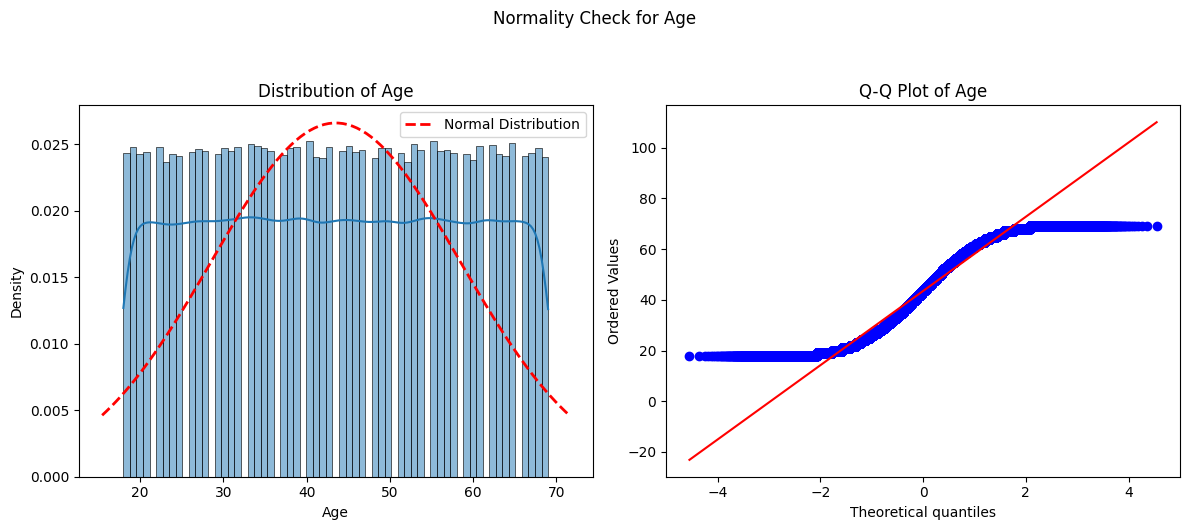


Shapiro-Wilk Test Results for Age:
Statistic: 0.9563
p-value: 0.0000
The feature is not normally distributed (rejects null hypothesis)

Skewness: 0.0007
Kurtosis: -1.1984




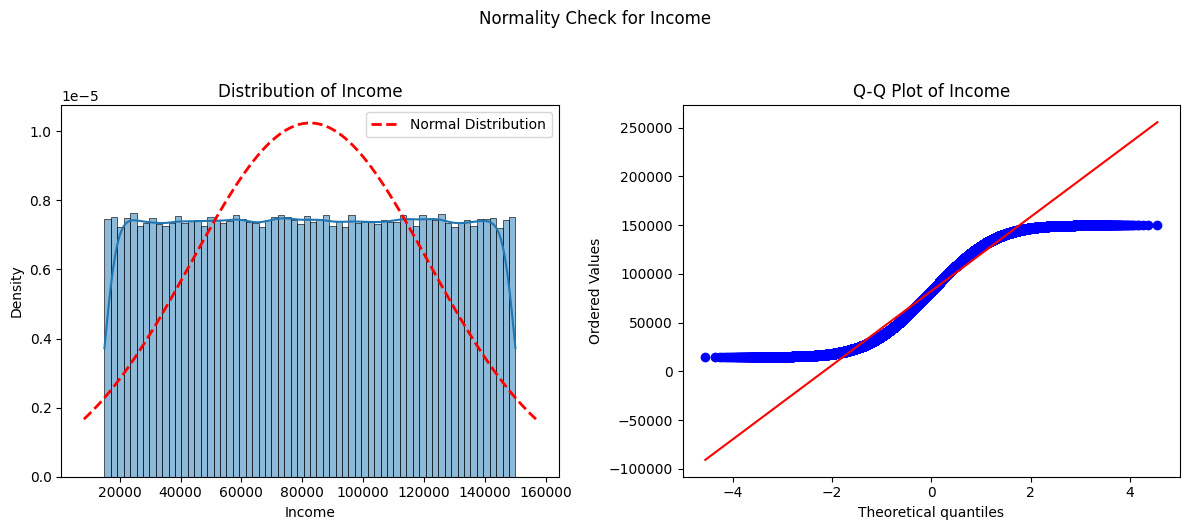


Shapiro-Wilk Test Results for Income:
Statistic: 0.9533
p-value: 0.0000
The feature is not normally distributed (rejects null hypothesis)

Skewness: -0.0004
Kurtosis: -1.1984




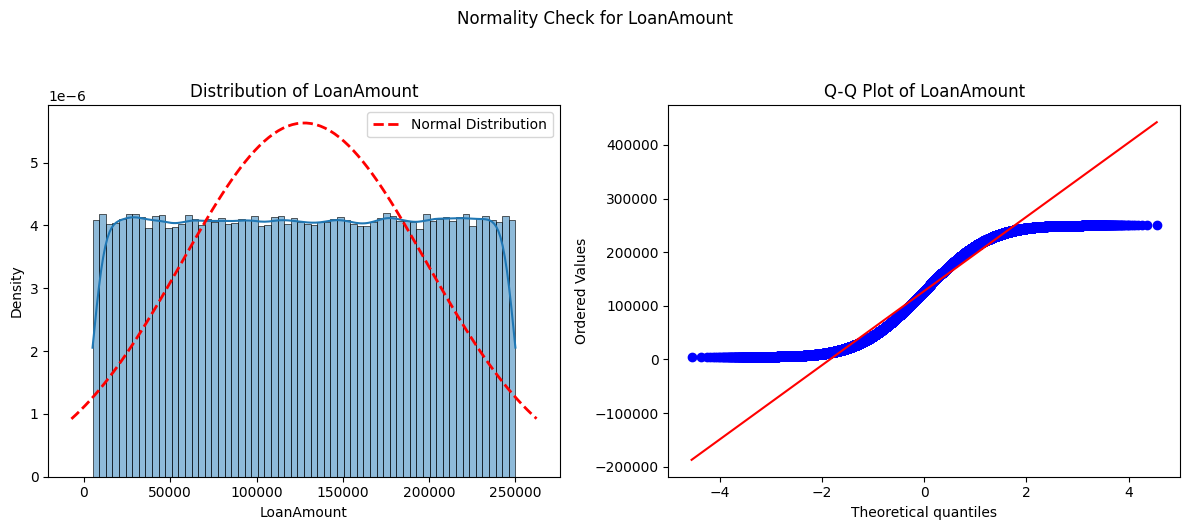


Shapiro-Wilk Test Results for LoanAmount:
Statistic: 0.9543
p-value: 0.0000
The feature is not normally distributed (rejects null hypothesis)

Skewness: -0.0018
Kurtosis: -1.2037




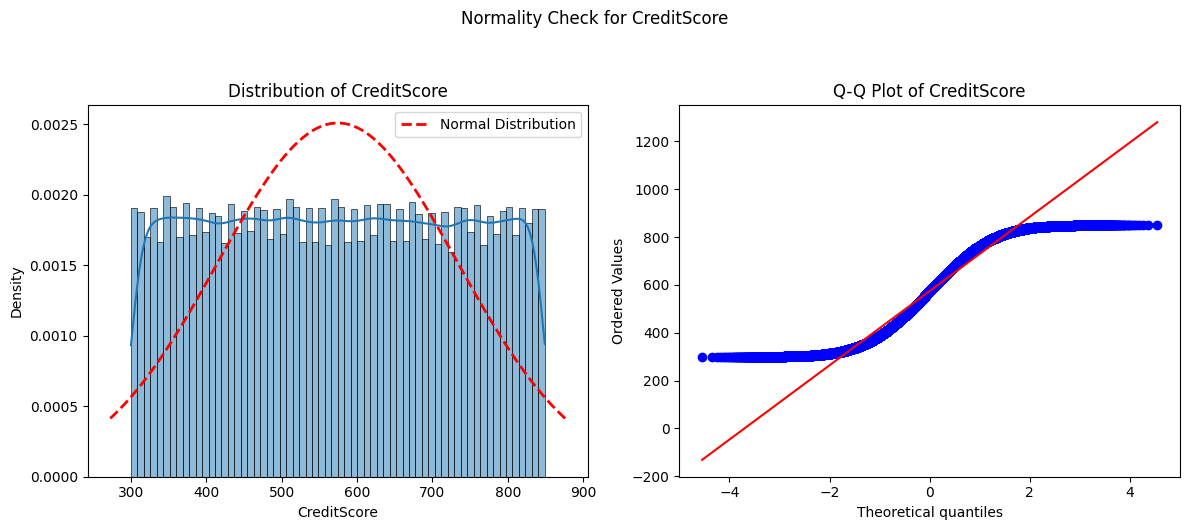


Shapiro-Wilk Test Results for CreditScore:
Statistic: 0.9556
p-value: 0.0000
The feature is not normally distributed (rejects null hypothesis)

Skewness: 0.0047
Kurtosis: -1.2003




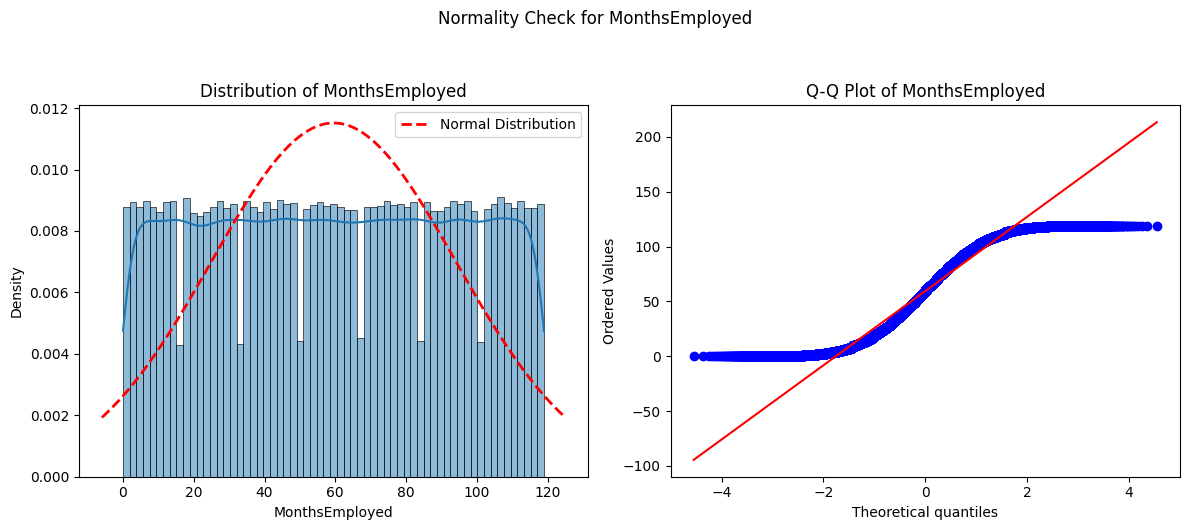


Shapiro-Wilk Test Results for MonthsEmployed:
Statistic: 0.9547
p-value: 0.0000
The feature is not normally distributed (rejects null hypothesis)

Skewness: -0.0021
Kurtosis: -1.1996




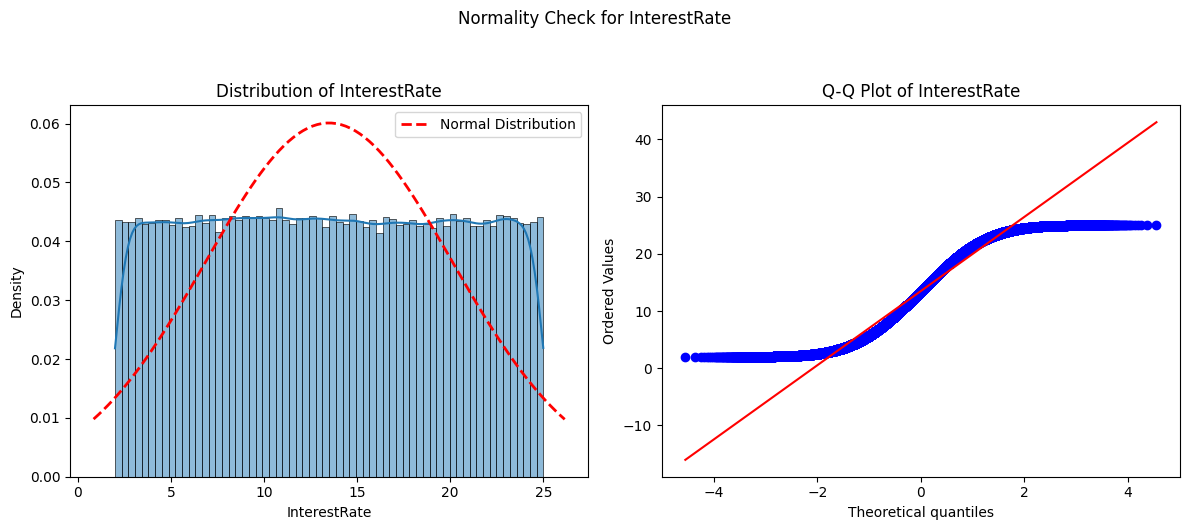


Shapiro-Wilk Test Results for InterestRate:
Statistic: 0.9555
p-value: 0.0000
The feature is not normally distributed (rejects null hypothesis)

Skewness: 0.0046
Kurtosis: -1.1972




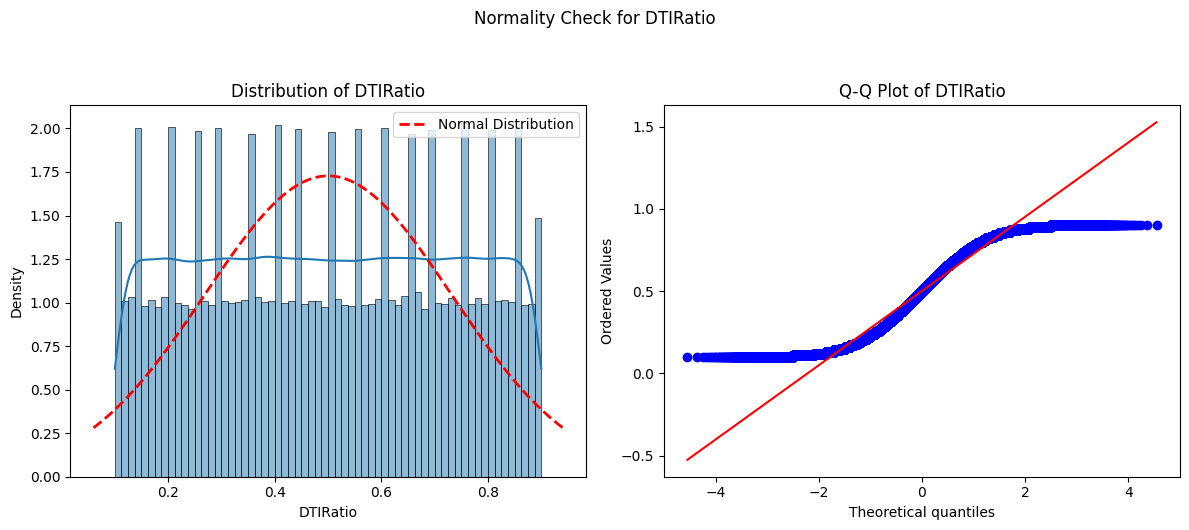


Shapiro-Wilk Test Results for DTIRatio:
Statistic: 0.9531
p-value: 0.0000
The feature is not normally distributed (rejects null hypothesis)

Skewness: -0.0015
Kurtosis: -1.1997




In [14]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

check_all_numeric_features(numeric_cols, exclude_cols=['LoanID', 'Default', 'NumCreditLines', 'LoanTerm'])

We can see here that the p-value for each column is zero, right away this tells us that our data is not normal in any numerical column. Similarly looking at the graphs, we see our histogram data does not match the bell-curve of normalised data, and similarly our data does not sit neatly on the trend lines in our Q-Q plot, all signs that we are not working with normalised data.

From here we can apply transofrmations to our data to make it more optimized for models that rely on normal data. Since we do not need our data to be normal in the analysis phase, we can simply continue with the data in it's current state, and later when choosing a model to train we can use one that does not rely on normalised data.

## Analyzing Risk

In [15]:
# Create new features
df['LoanToIncomeRatio'] = df['LoanAmount'] / df['Income']
df['RiskScore'] = (df['DTIRatio'] / df['CreditScore']) * 1000
df['MonthlyLoanBurden'] = (df['LoanAmount'] * (df['InterestRate']/1200)) / (1 - (1 + df['InterestRate']/1200)**(-df['LoanTerm']))
df['PaymentToIncome_Ratio'] = (df['MonthlyLoanBurden'] * 100) / (df['Income'] / 12)


DTI Ratio Ranges:
--------------------------------------------------
Band 1: 9.9% to 26.0%
Band 2: 26.0% to 42.0%
Band 3: 42.0% to 58.0%
Band 4: 58.0% to 74.0%
Band 5: 74.0% to 90.0%

Loan-to-Income Ratio Ranges:
--------------------------------------------------
Band 1: 0.03x to 0.65x annual income
Band 2: 0.65x to 1.25x annual income
Band 3: 1.25x to 1.86x annual income
Band 4: 1.86x to 3.13x annual income
Band 5: 3.13x to 16.53x annual income


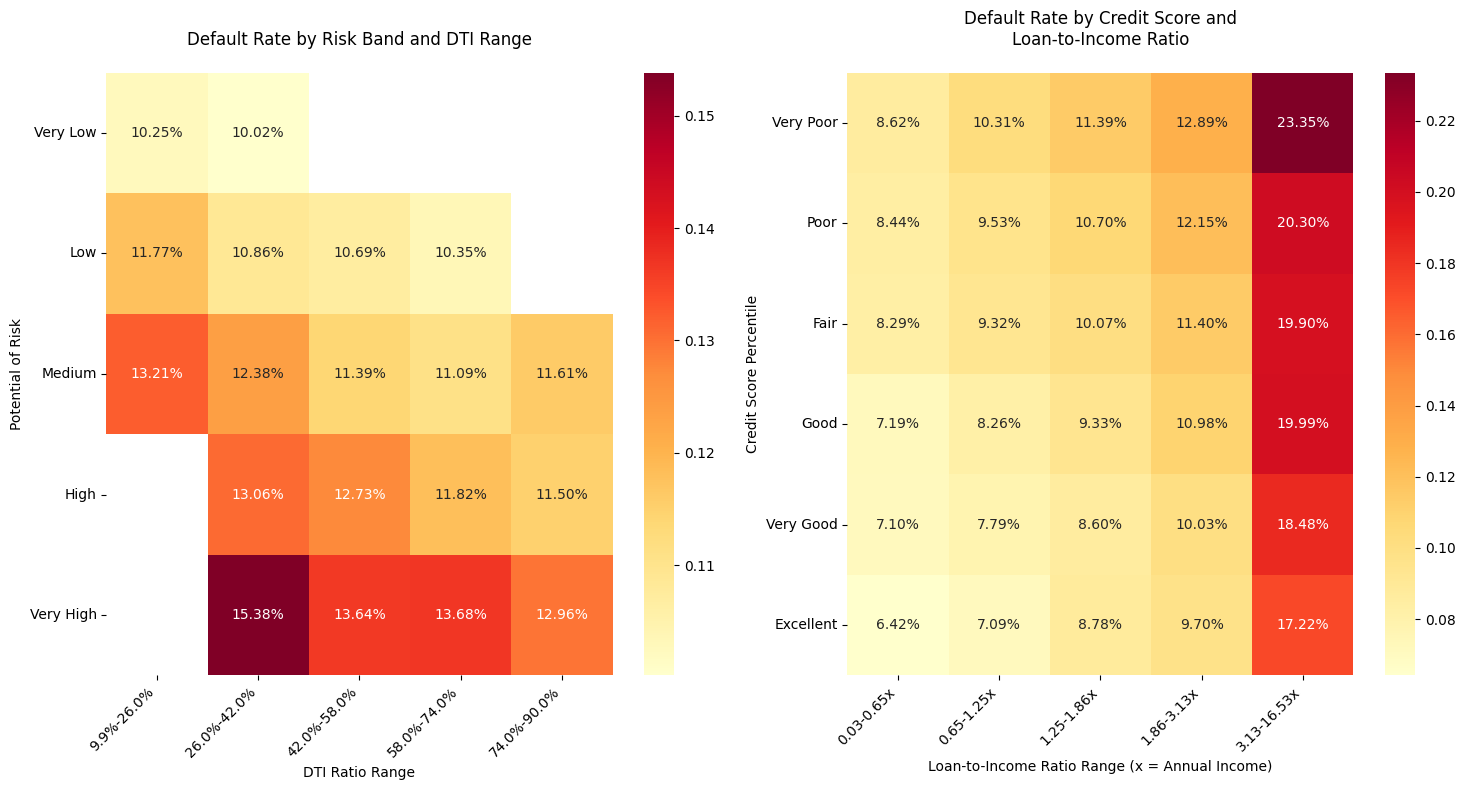


Risk Band Statistics:
--------------------------------------------------

Total number of loans: 255347

Breakdown by Risk Band:
           count  default_rate  num_defaults  percent_of_total
RiskBand                                                      
Very Low   51075         10.21          5213              20.0
Low        51064         10.98          5607              20.0
Medium     51072         11.56          5905              20.0
High       51069         12.02          6140              20.0
Very High  51067         13.29          6788              20.0

Columns:
- count: Number of loans in this risk band
- default_rate: Percentage of loans that defaulted in this band
- num_defaults: Number of defaults in this band
- percent_of_total: Percentage of total loans in this band


In [16]:
# Create bands for plot
df['RiskBand'] = pd.qcut(df['RiskScore'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
df['CreditScoreBand'] = pd.cut(df['CreditScore'],
                              bins=[300, 400, 500, 600, 700, 800, 850],
                              labels=['Very Poor', 'Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])

# Create DTI and LTI bins
dti_bins = pd.qcut(df['DTIRatio'], q=5)
df['LoanToIncomeRatio'] = df['LoanAmount'] / df['Income']
lti_bins = pd.qcut(df['LoanToIncomeRatio'], q=5)

print("\nDTI Ratio Ranges:")
print("-" * 50)
dti_ranges = [f"{interval.left:.1%}-{interval.right:.1%}"
             for interval in dti_bins.unique().categories]
for i, interval in enumerate(dti_bins.unique().categories, 1):
    print(f"Band {i}: {interval.left:.1%} to {interval.right:.1%}")

print("\nLoan-to-Income Ratio Ranges:")
print("-" * 50)
lti_ranges = [f"{interval.left:.2f}-{interval.right:.2f}x"
             for interval in lti_bins.unique().categories]
for i, interval in enumerate(lti_bins.unique().categories, 1):
    print(f"Band {i}: {interval.left:.2f}x to {interval.right:.2f}x annual income")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# 1. Default Rate by Risk Band and DTI
risk_dti_default = df.groupby(['RiskBand', dti_bins], observed=False)['Default'].mean().unstack()
risk_dti_default.columns = dti_ranges

sns.heatmap(risk_dti_default, annot=True, fmt='.2%', cmap='YlOrRd', ax=ax1)
ax1.set_title('Default Rate by Risk Band and DTI Range', pad=20)
ax1.set_xlabel('DTI Ratio Range')
ax1.set_ylabel('Potential of Risk')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# 2. Loan-to-Income Ratio vs Default Rate by Credit Score Band
lti_default = df.groupby(['CreditScoreBand', lti_bins], observed=False)['Default'].mean().unstack()
lti_default.columns = lti_ranges

sns.heatmap(lti_default, annot=True, fmt='.2%', cmap='YlOrRd', ax=ax2)
ax2.set_title('Default Rate by Credit Score and\nLoan-to-Income Ratio', pad=20)
ax2.set_xlabel('Loan-to-Income Ratio Range (x = Annual Income)')
ax2.set_ylabel('Credit Score Percentile')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Calculate Risk Band Statistics
risk_band_stats = df.groupby('RiskBand', observed=False)['Default'].agg([
    ('count', 'count'),
    ('default_rate', 'mean'),
    ('num_defaults', lambda x: x.sum())
]).round(4)

# Convert default rate to percentage
risk_band_stats['default_rate'] = (risk_band_stats['default_rate'] * 100).round(2)

# Add percentage of total loans column
risk_band_stats['percent_of_total'] = (risk_band_stats['count'] / risk_band_stats['count'].sum() * 100).round(2)

# Print Risk Band Statistics
print("\nRisk Band Statistics:")
print("-" * 50)
print(f"\nTotal number of loans: {df.shape[0]}")
print("\nBreakdown by Risk Band:")
print(risk_band_stats)
print("\nColumns:")
print("- count: Number of loans in this risk band")
print("- default_rate: Percentage of loans that defaulted in this band")
print("- num_defaults: Number of defaults in this band")
print("- percent_of_total: Percentage of total loans in this band")

Here we calculate the Potential of Risk as follows:

$\text{Potenital} = \frac{DTI Ratio}{Credit Score} \times 1000$

We see that:

* Just like we preidcted, customers with a higher risk score are way more likely to default
* Although customers with a high DTI ratio  (58% +) are usually more likely to default, the customers within the range of (26%-42%) show the highest default rates across all risk potentials
* This tells us that using DTI ratio to predict which customers will default may not be as predictable as other factors, like credit score and Loan-To-Income Ratio that show clear trends
> * (Higher credit score and lower LTI ratio has less chance of defaulting and vice versa)


Default Rate Statistics:
--------------------------------------------------

DTI Ratio Quartiles and Default Rates:
                   mean  count
DTIRatio                      
(0.099, 0.3]  10.659331  65248
(0.3, 0.5]    11.535095  63970
(0.5, 0.7]    11.987896  63781
(0.7, 0.9]    12.306730  62348

Credit Score Quartiles and Default Rates:
                       mean  count
CreditScore                       
(299.999, 437.0]  13.055815  64140
(437.0, 574.0]    11.894425  63803
(574.0, 712.0]    11.290222  63896
(712.0, 849.0]    10.197141  63508


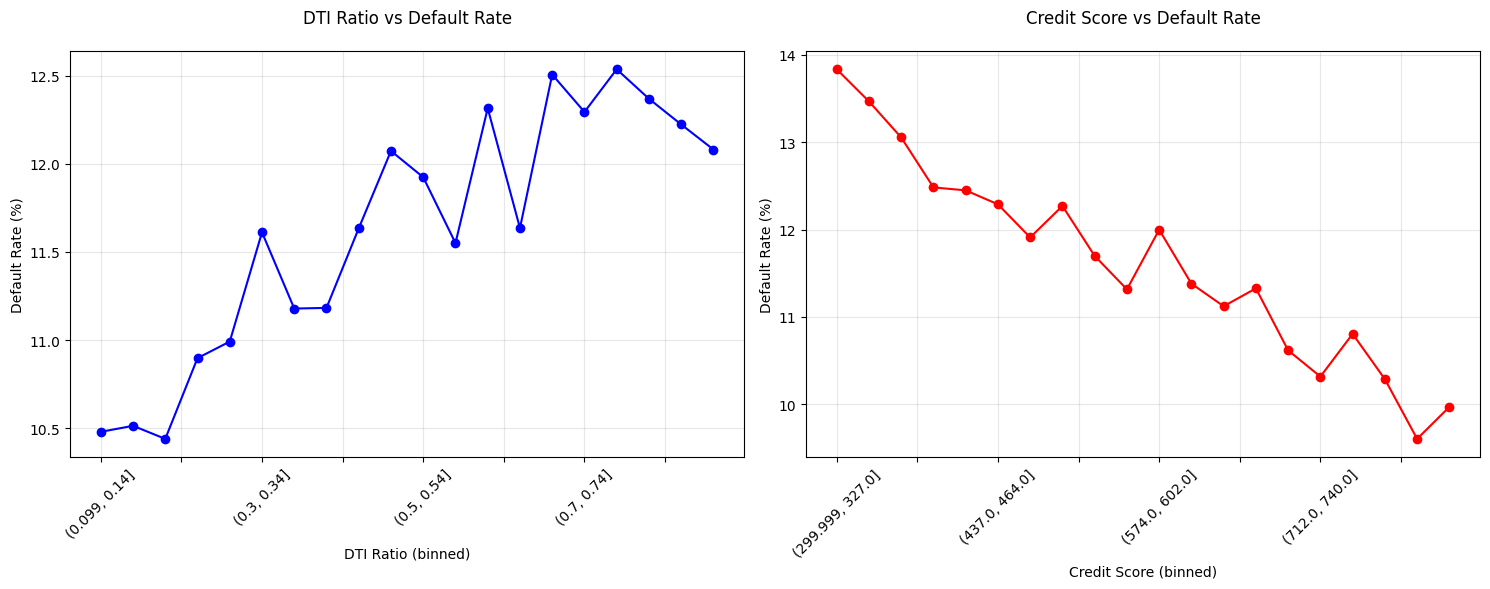

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: DTI Ratio vs Default Rate
# Create 20 bins of DTI Ratio and calculate mean default rate for each bin
dti_bins = pd.qcut(df['DTIRatio'], q=20)
default_by_dti = df.groupby(dti_bins, observed=False)['Default'].mean() * 100  # Convert to percentage

# Plot the DTI ratio vs default rate
default_by_dti.plot(kind='line', marker='o', color='blue', ax=ax1)
ax1.set_title('DTI Ratio vs Default Rate', pad=20)
ax1.set_xlabel('DTI Ratio (binned)')
ax1.set_ylabel('Default Rate (%)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Plot 2: Credit Score vs Default Rate
# Create 20 bins of Credit Score and calculate mean default rate for each bin
score_bins = pd.qcut(df['CreditScore'], q=20)
default_by_score = df.groupby(score_bins, observed=False)['Default'].mean() * 100  # Convert to percentage

# Plot the Credit Score vs default rate
default_by_score.plot(kind='line', marker='o', color='red', ax=ax2)
ax2.set_title('Credit Score vs Default Rate', pad=20)
ax2.set_xlabel('Credit Score (binned)')
ax2.set_ylabel('Default Rate (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()

# Print some summary statistics
print("\nDefault Rate Statistics:")
print("-" * 50)
print("\nDTI Ratio Quartiles and Default Rates:")
dti_quartiles = pd.qcut(df['DTIRatio'], q=4)
dti_default_rates = df.groupby(dti_quartiles, observed=False)['Default'].agg(['mean', 'count'])
dti_default_rates['mean'] = dti_default_rates['mean'] * 100
print(dti_default_rates)

print("\nCredit Score Quartiles and Default Rates:")
score_quartiles = pd.qcut(df['CreditScore'], q=4)
score_default_rates = df.groupby(score_quartiles, observed=False)['Default'].agg(['mean', 'count'])
score_default_rates['mean'] = score_default_rates['mean'] * 100
print(score_default_rates)

Plotting risk factors(DTI Ratio and Credit Score) by Default Rate we see clear trends indicating that a Higer DTI ratio and A lower credit score increases a customers chance of defaulting on their loan.

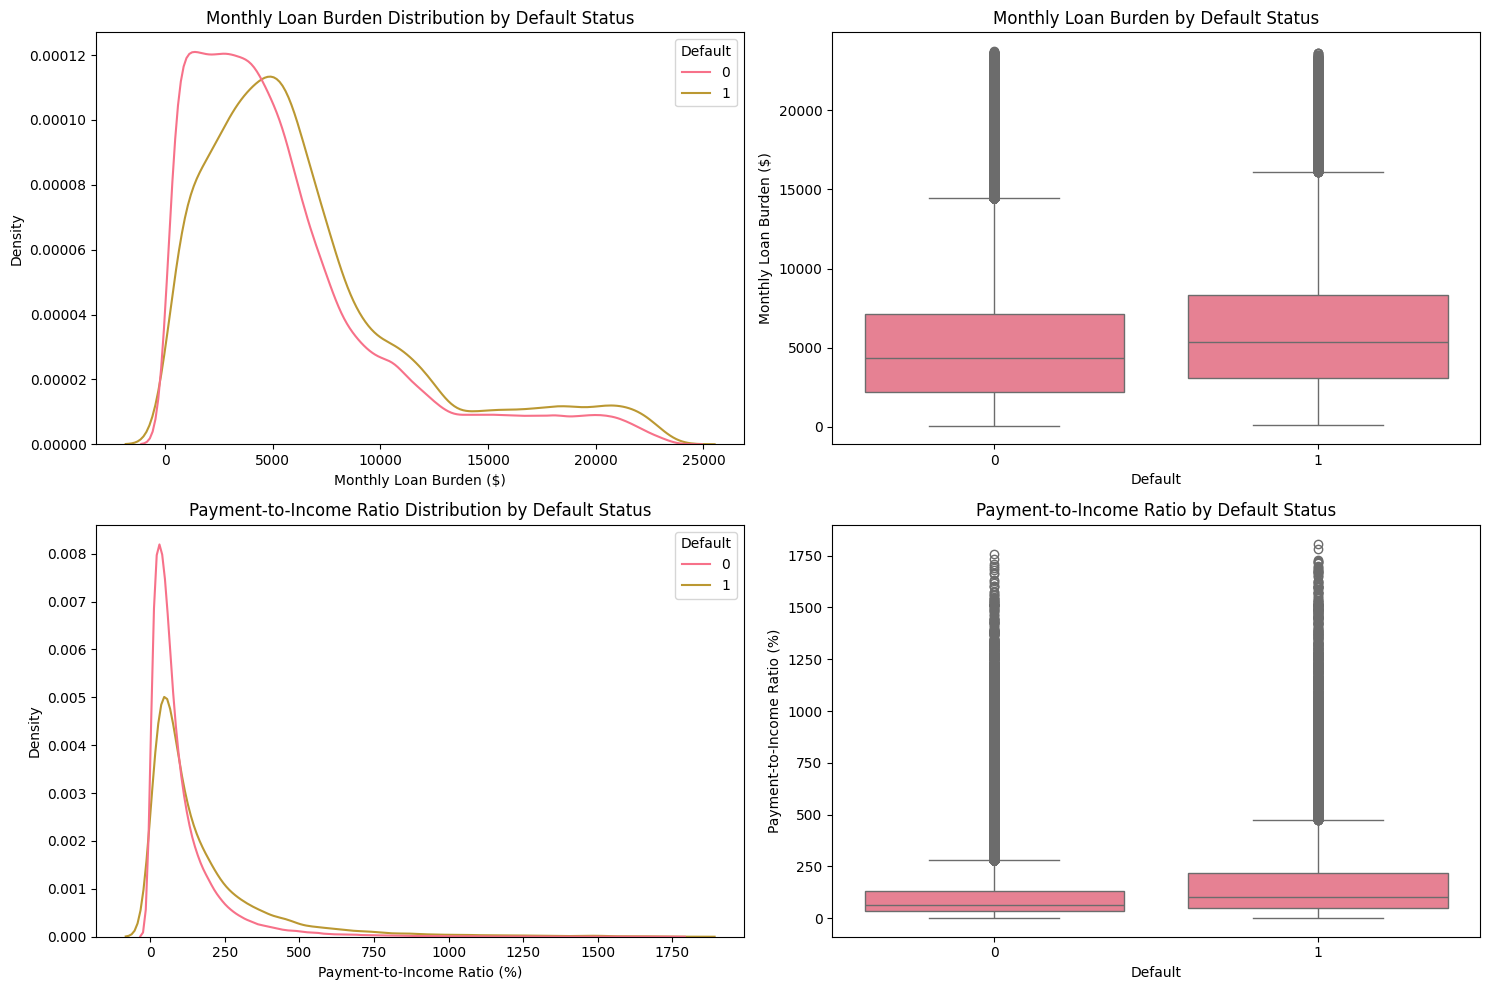

<ipython-input-18-60e55da54c11>:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = df.groupby('Payment_RiskBand')['Default'].mean() * 100
<ipython-input-18-60e55da54c11>:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = df.groupby('PTI_RiskBand')['Default'].mean() * 100


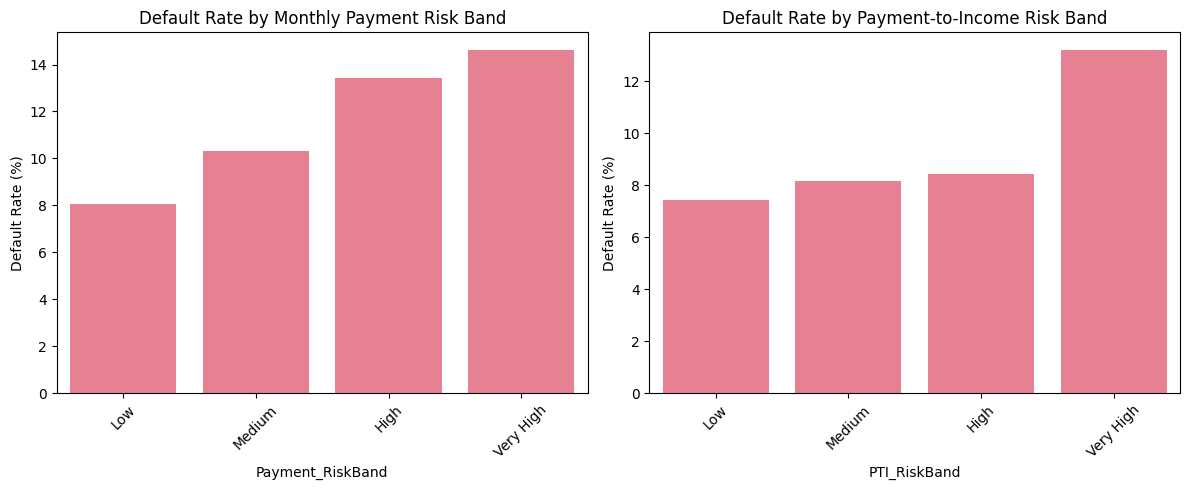

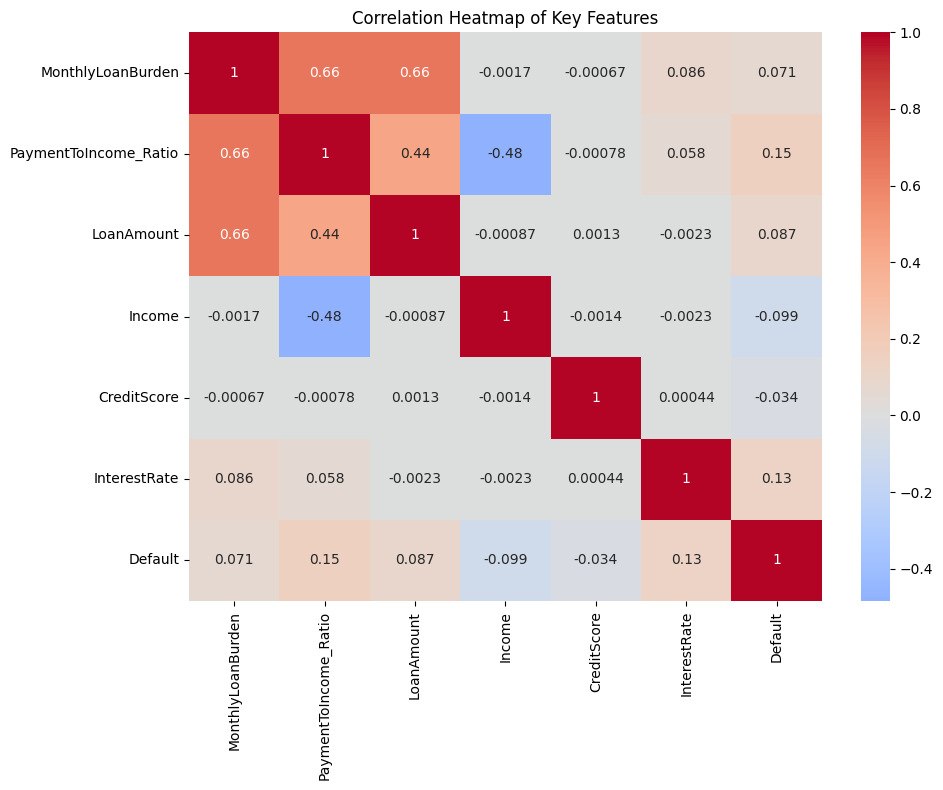


Monthly Loan Burden Statistics:
--------------------------------------------------
count    255347.00
mean       5649.06
std        4731.40
min          90.80
25%        2317.46
50%        4442.06
75%        7259.85
max       23735.67
Name: MonthlyLoanBurden, dtype: float64

Payment-to-Income Ratio Statistics:
--------------------------------------------------
count    255347.00
mean        115.73
std         146.64
min           0.82
25%          33.61
50%          68.25
75%         139.79
max        1808.61
Name: PaymentToIncome_Ratio, dtype: float64

Default Rates by Payment Risk Band:
--------------------------------------------------
                  count    mean
Payment_RiskBand               
Low               63837  0.0806
Medium            63837  0.1032
High              63836  0.1343
Very High         63837  0.1464

Default Rates by Payment-to-Income Risk Band:
--------------------------------------------------
               count    mean
PTI_RiskBand                
Low 

<ipython-input-18-60e55da54c11>:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('Payment_RiskBand')['Default'].agg(['count', 'mean']).round(4))
<ipython-input-18-60e55da54c11>:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('PTI_RiskBand')['Default'].agg(['count', 'mean']).round(4))


In [18]:
# Set up the plotting style
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(15, 10))

# 1. Monthly Loan Burden Analysis
plt.subplot(2, 2, 1)
sns.kdeplot(data=df, x='MonthlyLoanBurden', hue='Default', common_norm=False)
plt.title('Monthly Loan Burden Distribution by Default Status')
plt.xlabel('Monthly Loan Burden ($)')
plt.ylabel('Density')

plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='Default', y='MonthlyLoanBurden')
plt.title('Monthly Loan Burden by Default Status')
plt.ylabel('Monthly Loan Burden ($)')

# 2. Payment-to-Income Ratio Analysis
plt.subplot(2, 2, 3)
sns.kdeplot(data=df, x='PaymentToIncome_Ratio', hue='Default', common_norm=False)
plt.title('Payment-to-Income Ratio Distribution by Default Status')
plt.xlabel('Payment-to-Income Ratio (%)')
plt.ylabel('Density')

plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='Default', y='PaymentToIncome_Ratio')
plt.title('Payment-to-Income Ratio by Default Status')
plt.ylabel('Payment-to-Income Ratio (%)')

plt.tight_layout()
plt.show()

# Create risk band analysis
plt.figure(figsize=(12, 5))

# Monthly Payment Risk Bands
payment_bins = df['MonthlyLoanBurden'].quantile([0, 0.25, 0.5, 0.75, 1.0])
df['Payment_RiskBand'] = pd.qcut(df['MonthlyLoanBurden'], q=4,
                                labels=['Low', 'Medium', 'High', 'Very High'])

plt.subplot(1, 2, 1)
default_rates = df.groupby('Payment_RiskBand')['Default'].mean() * 100
sns.barplot(x=default_rates.index, y=default_rates.values)
plt.title('Default Rate by Monthly Payment Risk Band')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45)

# Payment-to-Income Risk Bands
pti_bins = [0, 20, 30, 40, float('inf')]
pti_labels = ['Low', 'Medium', 'High', 'Very High']
df['PTI_RiskBand'] = pd.cut(df['PaymentToIncome_Ratio'], bins=pti_bins, labels=pti_labels)

plt.subplot(1, 2, 2)
default_rates = df.groupby('PTI_RiskBand')['Default'].mean() * 100
sns.barplot(x=default_rates.index, y=default_rates.values)
plt.title('Default Rate by Payment-to-Income Risk Band')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Create correlation heatmap
correlation_features = ['MonthlyLoanBurden', 'PaymentToIncome_Ratio',
                       'LoanAmount', 'Income', 'CreditScore', 'InterestRate', 'Default']
correlation_matrix = df[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Key Features')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nMonthly Loan Burden Statistics:")
print("-" * 50)
print(df['MonthlyLoanBurden'].describe().round(2))

print("\nPayment-to-Income Ratio Statistics:")
print("-" * 50)
print(df['PaymentToIncome_Ratio'].describe().round(2))

# Print default rates by risk bands
print("\nDefault Rates by Payment Risk Band:")
print("-" * 50)
print(df.groupby('Payment_RiskBand')['Default'].agg(['count', 'mean']).round(4))

print("\nDefault Rates by Payment-to-Income Risk Band:")
print("-" * 50)
print(df.groupby('PTI_RiskBand')['Default'].agg(['count', 'mean']).round(4))

# ML Model Evaluation

* Here we will be testing the performance of various types of ML Models and choosing the best model for our data

## Pre Processing

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

def handle_missing_values(df):
    """Impute missing values appropriately"""
    data = df.copy()

    # Separate numerical and categorical columns
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = data.select_dtypes(include=['object']).columns

    # Impute numerical columns with median
    numeric_imputer = SimpleImputer(strategy='median')
    data[numeric_columns] = numeric_imputer.fit_transform(data[numeric_columns])

    # Impute categorical columns with mode
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

    if data.isnull().values.any():
        print("WARNING: There are still NaN values in the dataset after imputation!")
        print("Investigate and fix the source of these missing values.")
        print(data.isnull().sum()) # Print the columns with NaN values for debugging

    return data

    return data

def handle_outliers(df):
    """Handle outliers in numerical columns"""
    data = df.copy()

    # List of columns to check for outliers
    columns_to_check = ['Age', 'Income', 'LoanAmount', 'MonthsEmployed',
                       'NumCreditLines', 'InterestRate', 'DTIRatio',
                       'MonthlyLoanBurden', 'PaymentToIncome_Ratio',]

    for column in columns_to_check:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)

    return data

def encode_categorical_variables(df):
    """Encode categorical variables appropriately"""

    data = df.copy()

    if not isinstance(df, pd.DataFrame):
      raise TypeError("Input must be a pandas DataFrame")

    # Binary encoding for yes/no variables
    binary_columns = ['HasMortgage', 'HasDependents', 'HasCoSigner']

    # Binary encoding
    if binary_columns:
        for col in binary_columns:
            data[col] = data[col].map({'Yes': 1, 'No': 0})

    # Direct mapping is the only strategy that works here

    data['Education'] = data['Education'].map({"High School": 1,
                                           "Bachelor's": 2,
                                           "Master's": 3,
                                           "PhD": 4})

    data['EmploymentType'] = data['EmploymentType'].map({"Unemployed": 1,
                                                     "Self-employed": 2,
                                                     "Part-time": 3,
                                                     "Full-time": 4})

    data['MaritalStatus'] = data['MaritalStatus'].map({"Single": 1,
                                                    "Married": 2,
                                                    "Divorced": 3})

    data['LoanPurpose'] = data['LoanPurpose'].map({"Auto": 1,
                                               "Business": 2,
                                               "Education": 3,
                                               "Home": 4,
                                               "Other": 5})

    return data


# Step 5: Feature scaling
def scale_features(df):
    """Scale numerical features"""
    data = df.copy()

    # Identify numerical columns to scale (exclude target variable and ID)
    columns_to_scale = data.select_dtypes(include=['int64', 'float64']).columns
    columns_to_scale = columns_to_scale.drop('Default')  # Exclude target variable
    if 'LoanID' in columns_to_scale:
        columns_to_scale = columns_to_scale.drop('LoanID')  # Exclude ID

    # Scale the features
    scaler = StandardScaler()
    data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

    return data

# Main preprocessing pipeline
def preprocess_data(df, test_size=0.2, random_state=42):
    """Complete preprocessing pipeline"""

    print("Starting preprocessing pipeline...")

    print("Handling missing values...")
    df= handle_missing_values(df)

    print("Handling outliers...")
    df = handle_outliers(df)

    print("Encoding categorical variables...")
    df = encode_categorical_variables(df)

    print("Scaling features...")
    df = scale_features(df)

    print("Splitting the data...")

    # Remove LoanID if present
    if 'LoanID' in df.columns:
        df = df.drop('LoanID', axis=1)

    # Remove Band columns
    if 'RiskBand' in df.columns:
        df = df.drop('RiskBand', axis=1)
    if 'CreditScoreBand' in df.columns:
        df = df.drop('CreditScoreBand', axis=1)
    if 'Payment_RiskBand' in df.columns:
        df = df.drop('Payment_RiskBand', axis=1)
    if 'PTI_RiskBand' in df.columns:
        df = df.drop('PTI_RiskBand', axis=1)

    # Split features and target
    X = df.drop('Default', axis=1)
    y = df['Default']

    if X.isnull().values.any():
        print("ERROR: NaN values present in features after preprocessing.")
        print("Investigate and fix the source of these missing values.")
        print(X.isnull().sum()) # Print the columns with NaN values for debugging
        # You can choose to either impute the remaining NaNs here
        # or raise an exception to stop the process.

    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=y)

    print("Preprocessing complete!")
    return X_train, X_test, y_train, y_test

# Execute preprocessing
X_train, X_test, y_train, y_test = preprocess_data(df)

# Print shapes of resulting datasets
print("\nFinal dataset shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Print feature names
print("\nFinal features:")
print(X_train.columns.tolist())

Starting preprocessing pipeline...
Handling missing values...
Investigate and fix the source of these missing values.
LoanID                     0
Age                        0
Income                     0
LoanAmount                 0
CreditScore                0
MonthsEmployed             0
NumCreditLines             0
InterestRate               0
LoanTerm                   0
DTIRatio                   0
Education                  0
EmploymentType             0
MaritalStatus              0
HasMortgage                0
HasDependents              0
LoanPurpose                0
HasCoSigner                0
Default                    0
LoanToIncomeRatio          0
RiskScore                  0
MonthlyLoanBurden          0
PaymentToIncome_Ratio      0
RiskBand                   0
CreditScoreBand          484
Payment_RiskBand           0
PTI_RiskBand               0
dtype: int64
Handling outliers...
Encoding categorical variables...
Scaling features...
Splitting the data...
Preprocessing comp

<ipython-input-20-3a8e976050c2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Default', data=pd.concat([X_train, y_train], axis=1), palette='Set2', ax=axes[0])
<ipython-input-20-3a8e976050c2>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='Set2', ax=axes[1])


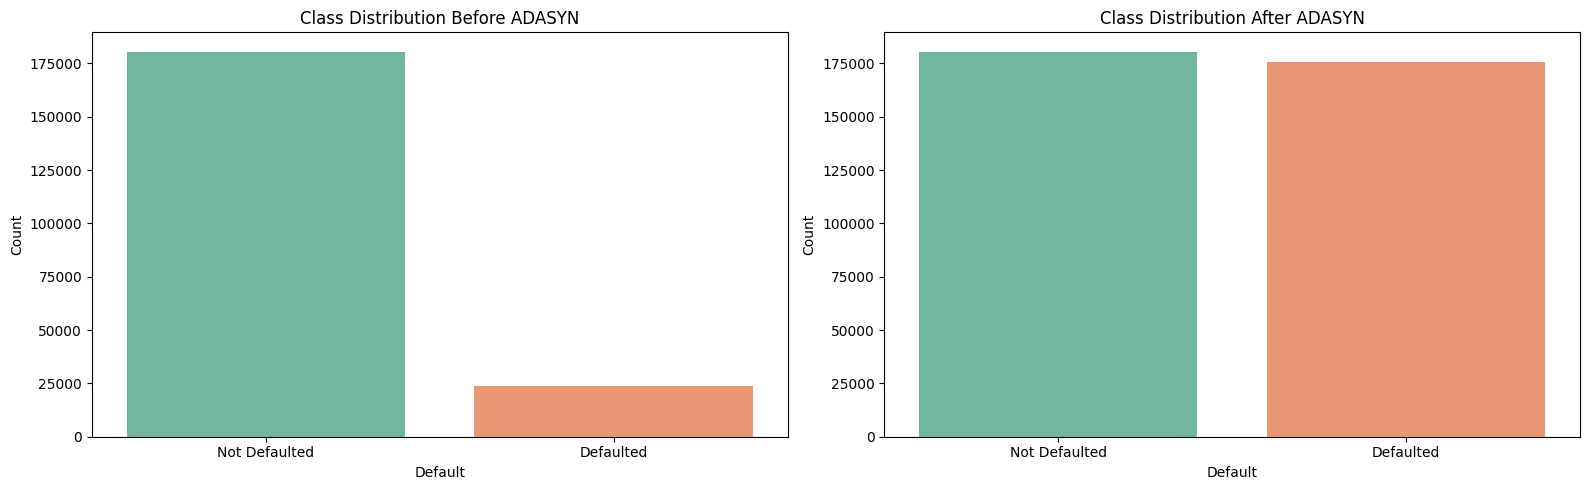

Before   After
Default                
0.0      180555  180555
1.0       23722  175618

In [20]:
from imblearn.over_sampling import ADASYN

# Creating subplots for class distribution before and after ADASYN
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plotting class distribution before ADASYN
sns.countplot(x='Default', data=pd.concat([X_train, y_train], axis=1), palette='Set2', ax=axes[0])
axes[0].set_title('Class Distribution Before ADASYN')
axes[0].set_xlabel('Default')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Not Defaulted', 'Defaulted'])

# Applying ADASYN to balance the classes
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Plotting class distribution after ADASYN
sns.countplot(x=y_resampled, palette='Set2', ax=axes[1])
axes[1].set_title('Class Distribution After ADASYN')
axes[1].set_xlabel('Default')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Not Defaulted', 'Defaulted'])

plt.tight_layout()
plt.show()

# Creating a DataFrame to compare before and after
before_count = pd.Series(y_train).value_counts()
after_count = pd.Series(y_resampled).value_counts()

# Creating a DataFrame for better visualization
comparison_df = pd.DataFrame({
    'Before': before_count,
    'After': after_count
})

comparison_df

## Model Comparison

In [21]:
!pip install --upgrade scikit-learn xgboost
!pip install --upgrade scikit-learn
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 54.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.2 MB/s eta 0:00:00


### Logistic Regression

Training Logistic Regression model...

Logistic Regression Model Performance:
Accuracy: 0.6881
Precision: 0.2260
Recall: 0.6950
F1 Score: 0.3410
ROC AUC: 0.7589

Cross-validation ROC AUC scores: [0.75522751 0.75596862 0.74853733 0.75584517 0.7550558 ]
Mean CV ROC AUC: 0.7541 (+/- 0.0056)


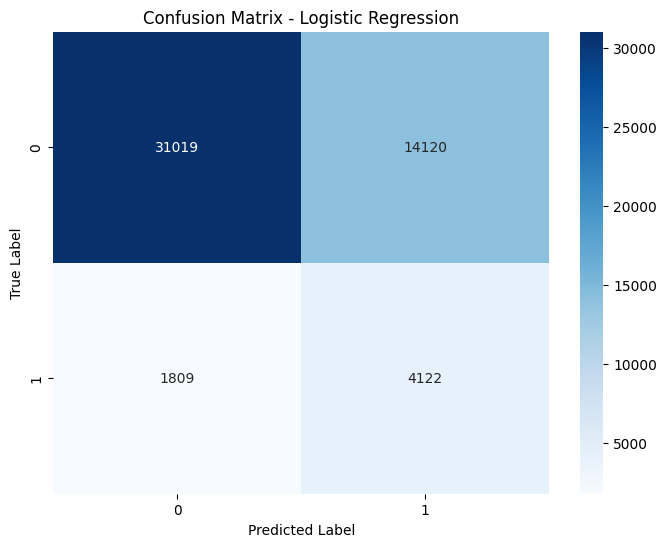


Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.69      0.80     45139
         1.0       0.23      0.69      0.34      5931

    accuracy                           0.69     51070
   macro avg       0.59      0.69      0.57     51070
weighted avg       0.86      0.69      0.74     51070



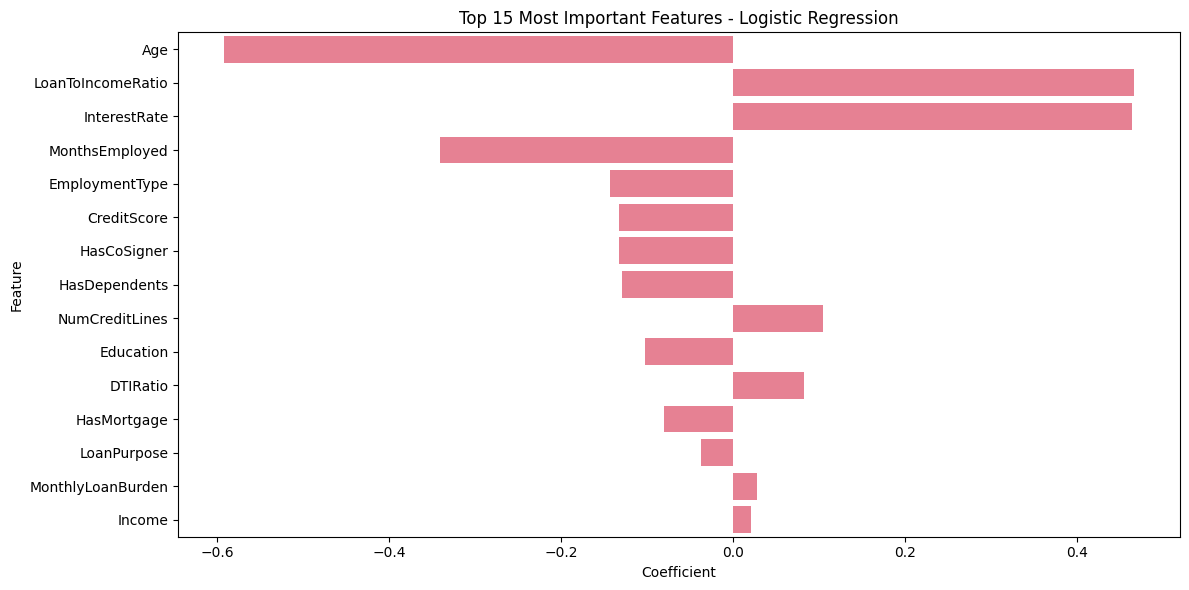


Top 10 Most Important Features:
              Feature  Coefficient
0                 Age    -0.592350
16  LoanToIncomeRatio     0.466810
6        InterestRate     0.463416
4      MonthsEmployed    -0.340612
10     EmploymentType    -0.142693
3         CreditScore    -0.132835
15        HasCoSigner    -0.132220
13      HasDependents    -0.129222
5      NumCreditLines     0.104981
9           Education    -0.102320


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score


def evaluate_logistic_regression(X_train, X_test, y_train, y_test):
    """
    Evaluate Logistic Regression model with comprehensive metrics and visualizations
    """
    lr_model = LogisticRegression(
        max_iter=1000,        # Increase max iterations for convergence
        random_state=42,      # For reproducibility
        class_weight='balanced' # Handle class imbalance
    )

    print("Training Logistic Regression model...")
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.predict(X_test)
    y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

    logistic_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba)
    }

    cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='roc_auc')

    print("\nLogistic Regression Model Performance:")
    for metric, value in logistic_metrics.items():
        print(f"{metric}: {value:.4f}")
    print(f"\nCross-validation ROC AUC scores: {cv_scores}")
    print(f"Mean CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Logistic Regression')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': lr_model.coef_[0]
    })
    feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Most Important Features - Logistic Regression')
    plt.tight_layout()
    plt.show()

    return lr_model, logistic_metrics, feature_importance

model, logistic_metrics, feature_importance = evaluate_logistic_regression(X_train, X_test, y_train, y_test)

Results:

* For non-defaults (0.0):

> - Precision: 0.94 (very good at identifying non-defaults)
> - Recall: 0.69 (captures about 69% of actual non-defaults)
> - F1-score: 0.80 (good balance)


* For defaults (1.0):

> - Precision: 0.23 (many false positives)
> - Recall: 0.69 (captures 69% of actual defaults)
> - F1-score: 0.34 (relatively low due to poor precision)

### Random Forest

Training Random Forest model...

Random Forest Model Performance:
Accuracy: 0.8850
Precision: 0.5881
Recall: 0.0315
F1 Score: 0.0598
ROC AUC: 0.7331

Cross-validation ROC AUC scores: [0.72624284 0.7281411  0.72067707 0.72685172 0.72634799]
Mean CV ROC AUC: 0.7257 (+/- 0.0052)


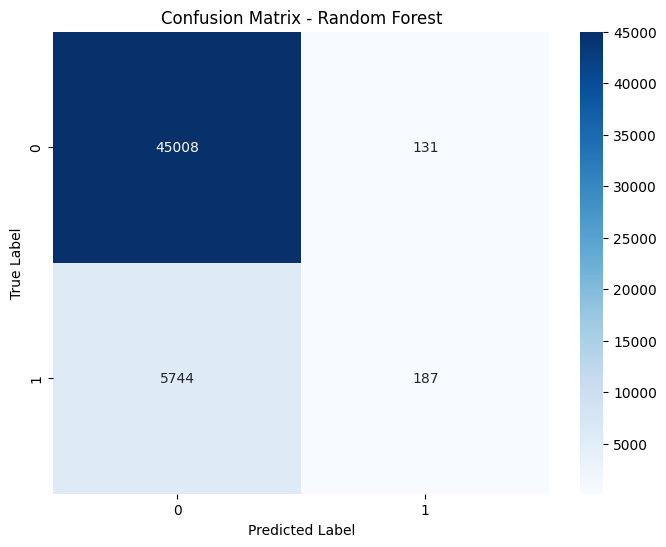


Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     45139
         1.0       0.59      0.03      0.06      5931

    accuracy                           0.88     51070
   macro avg       0.74      0.51      0.50     51070
weighted avg       0.85      0.88      0.84     51070



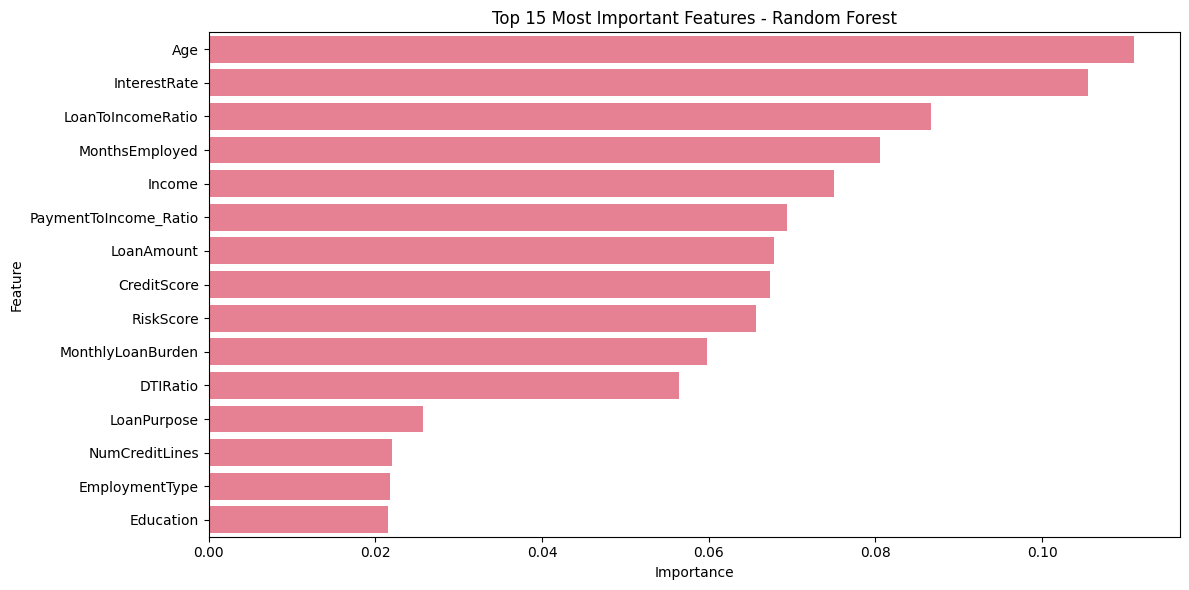


Top 10 Most Important Features:
                  Feature  Importance
0                     Age    0.110986
6            InterestRate    0.105556
16      LoanToIncomeRatio    0.086718
4          MonthsEmployed    0.080514
1                  Income    0.075025
19  PaymentToIncome_Ratio    0.069429
2              LoanAmount    0.067804
3             CreditScore    0.067338
17              RiskScore    0.065645
18      MonthlyLoanBurden    0.059769


In [28]:
from sklearn.ensemble import RandomForestClassifier

def evaluate_random_forest(X_train, X_test, y_train, y_test):
    """
    Evaluate Random Forest model with comprehensive metrics and visualizations
    """
    rf_model = RandomForestClassifier(
        n_estimators=100,     # Number of trees
        max_depth=None,       # Maximum depth of trees
        min_samples_split=2,  # Minimum samples required to split
        min_samples_leaf=1,   # Minimum samples required at leaf node
        random_state=42,      # For reproducibility
        class_weight='balanced'  # Handle class imbalance
    )

    print("Training Random Forest model...")
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

    rf_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba)
    }

    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')

    print("\nRandom Forest Model Performance:")
    for metric, value in rf_metrics.items():
        print(f"{metric}: {value:.4f}")
    print(f"\nCross-validation ROC AUC scores: {cv_scores}")
    print(f"Mean CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Random Forest')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Most Important Features - Random Forest')
    plt.tight_layout()
    plt.show()

    return rf_model, rf_metrics, feature_importance

model, rf_metrics, feature_importance = evaluate_random_forest(X_train, X_test, y_train, y_test)

* Non-defaults (0.0):

> - Precision: 0.89 (very good at identifying non-defaults)
> - Recall: 1.00 (almost perfect at catching non-defaults)
> - F1-score: 0.94 (excellent balance)


Defaults (1.0):

> - Precision: 0.59 (59% of predicted defaults are actual defaults - much better than Logistic Regression's 23%)
> - Recall: 0.03 (only catches 3.15% of actual defaults - much worse than Logistic Regression's 69%)
> - F1-score: 0.06 (very low due to poor recall)

### XGBoost

Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:31:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:31:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:31:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:31:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:32:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


XGBoost Model Performance:
Accuracy: 0.8861
Precision: 0.5824
Recall: 0.0679
F1 Score: 0.1217
ROC AUC: 0.7572

Cross-validation ROC AUC scores: [0.74761156 0.75332807 0.74482373 0.75210206 0.75153418]
Mean CV ROC AUC: 0.7499 (+/- 0.0063)


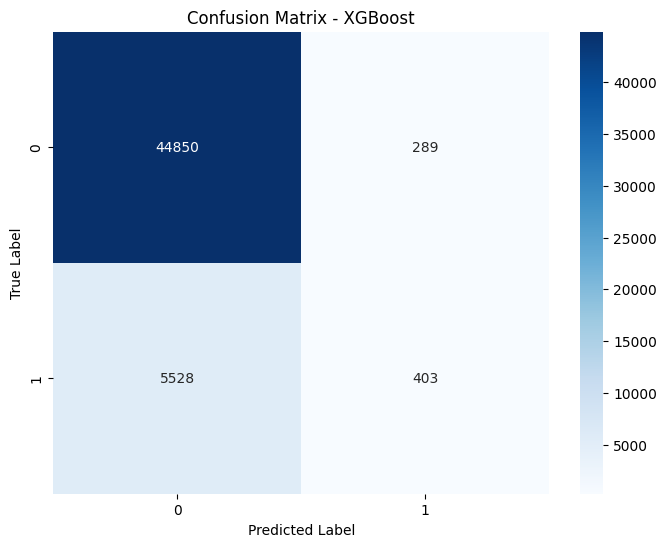


Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94     45139
         1.0       0.58      0.07      0.12      5931

    accuracy                           0.89     51070
   macro avg       0.74      0.53      0.53     51070
weighted avg       0.85      0.89      0.84     51070



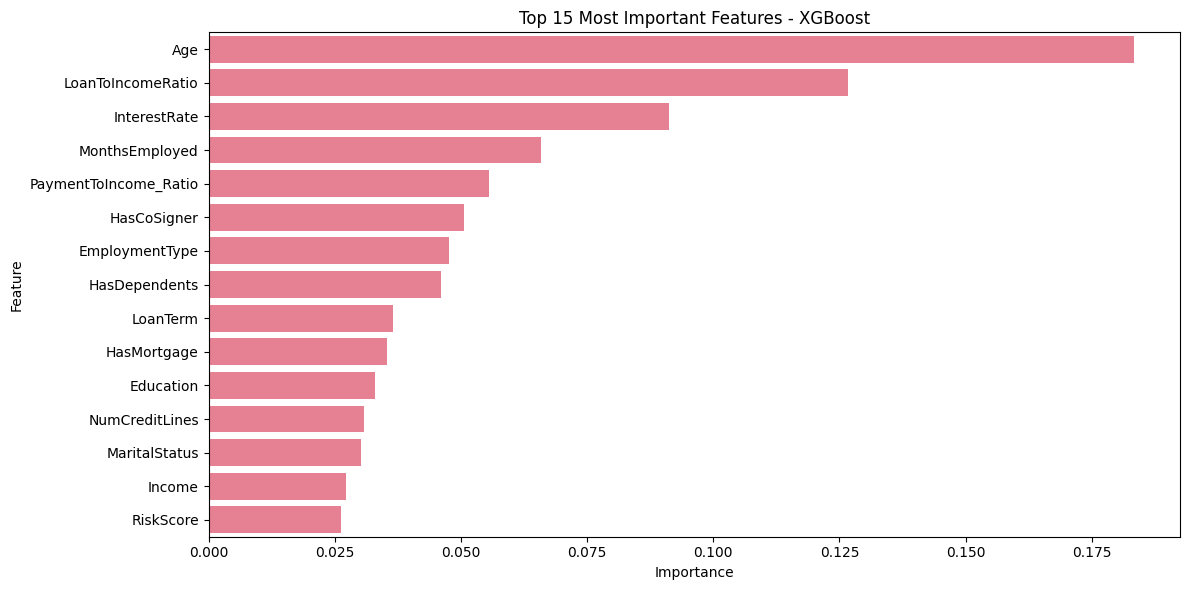


Top 10 Most Important Features:
                  Feature  Importance
0                     Age    0.183317
16      LoanToIncomeRatio    0.126786
6            InterestRate    0.091174
4          MonthsEmployed    0.065850
19  PaymentToIncome_Ratio    0.055498
15            HasCoSigner    0.050691
10         EmploymentType    0.047679
13          HasDependents    0.046057
7                LoanTerm    0.036611
12            HasMortgage    0.035384


In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

def custom_cross_val_score(model, X, y, cv):
    """
    Custom implementation of cross-validation scoring
    """
    cv_scores = []
    for train_idx, val_idx in cv.split(X, y):
        # Split data
        X_train_cv = X.iloc[train_idx] if isinstance(X, pd.DataFrame) else X[train_idx]
        X_val_cv = X.iloc[val_idx] if isinstance(X, pd.DataFrame) else X[val_idx]
        y_train_cv = y.iloc[train_idx] if isinstance(y, pd.Series) else y[train_idx]
        y_val_cv = y.iloc[val_idx] if isinstance(y, pd.Series) else y[val_idx]

        # Train model
        model_cv = XGBClassifier(**model.get_params())
        model_cv.fit(X_train_cv, y_train_cv)

        # Get predictions
        y_pred_proba = model_cv.predict_proba(X_val_cv)[:, 1]

        # Calculate ROC AUC
        cv_score = roc_auc_score(y_val_cv, y_pred_proba)
        cv_scores.append(cv_score)

    return np.array(cv_scores)

def evaluate_xgboost(X_train, X_test, y_train, y_test):
    """
    Evaluate XGBoost model with comprehensive metrics and visualizations
    """
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        objective='binary:logistic'
    )

    # Convert data to appropriate format if needed
    if isinstance(X_train, pd.DataFrame):
        X_train_arr = X_train.values
        X_test_arr = X_test.values
    else:
        X_train_arr = X_train
        X_test_arr = X_test

    if isinstance(y_train, pd.Series):
        y_train_arr = y_train.values
        y_test_arr = y_test.values
    else:
        y_train_arr = y_train
        y_test_arr = y_test

    print("Training XGBoost model...")
    xgb_model.fit(X_train_arr, y_train_arr)

    y_pred = xgb_model.predict(X_test_arr)
    y_pred_proba = xgb_model.predict_proba(X_test_arr)[:, 1]

    xgb_metrics = {
        'Accuracy': accuracy_score(y_test_arr, y_pred),
        'Precision': precision_score(y_test_arr, y_pred),
        'Recall': recall_score(y_test_arr, y_pred),
        'F1 Score': f1_score(y_test_arr, y_pred),
        'ROC AUC': roc_auc_score(y_test_arr, y_pred_proba)
    }

    # Custom cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = custom_cross_val_score(xgb_model, X_train, y_train, cv)

    print("\nXGBoost Model Performance:")
    for metric, value in xgb_metrics.items():
        print(f"{metric}: {value:.4f}")
    print(f"\nCross-validation ROC AUC scores: {cv_scores}")
    print(f"Mean CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test_arr, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - XGBoost')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test_arr, y_pred))

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns if isinstance(X_train, pd.DataFrame) else [f'F{i}' for i in range(X_train.shape[1])],
        'Importance': xgb_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Most Important Features - XGBoost')
    plt.tight_layout()
    plt.show()

    return xgb_model, xgb_metrics, feature_importance

model, xgb_metrics, feature_importance = evaluate_xgboost(X_train, X_test, y_train, y_test)

* Non-defaults (0.0):

> - Precision: 0.89 (89% of predicted non-defaults are actual non-defaults)
> - Recall: 0.99 (99% of actual non-defaults are correctly identified)
> - F1-score: 0.94 (excellent balance)


* Defaults (1.0):

> - Precision: 0.58 (58% of predicted defaults are actual defaults)
> - Recall: 0.07 (catches 7% of actual defaults)
> - F1-score: 0.12 (low due to poor recall)

### Gradient Boosting

Training Gradient Boosting model...

Gradient Boosting Model Performance:
Accuracy: 0.8863
Precision: 0.6006
Recall: 0.0629
F1 Score: 0.1139
ROC AUC: 0.7590

Cross-validation ROC AUC scores: [0.74896761 0.75626044 0.74813013 0.75410366 0.75396136]
Mean CV ROC AUC: 0.7523 (+/- 0.0063)


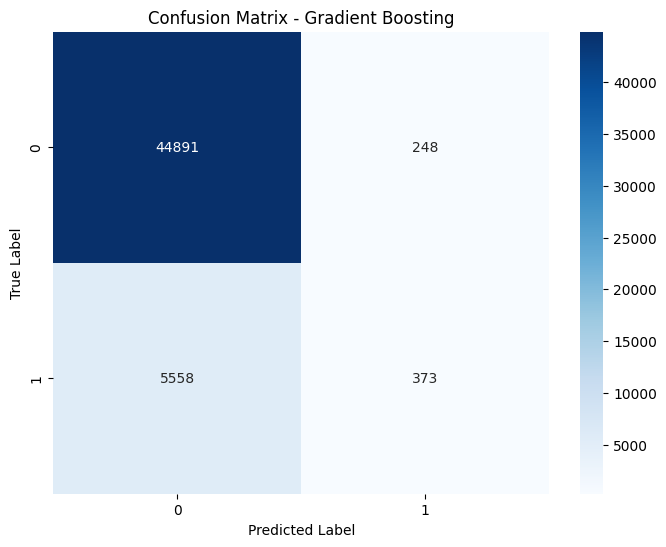


Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94     45139
         1.0       0.60      0.06      0.11      5931

    accuracy                           0.89     51070
   macro avg       0.75      0.53      0.53     51070
weighted avg       0.86      0.89      0.84     51070



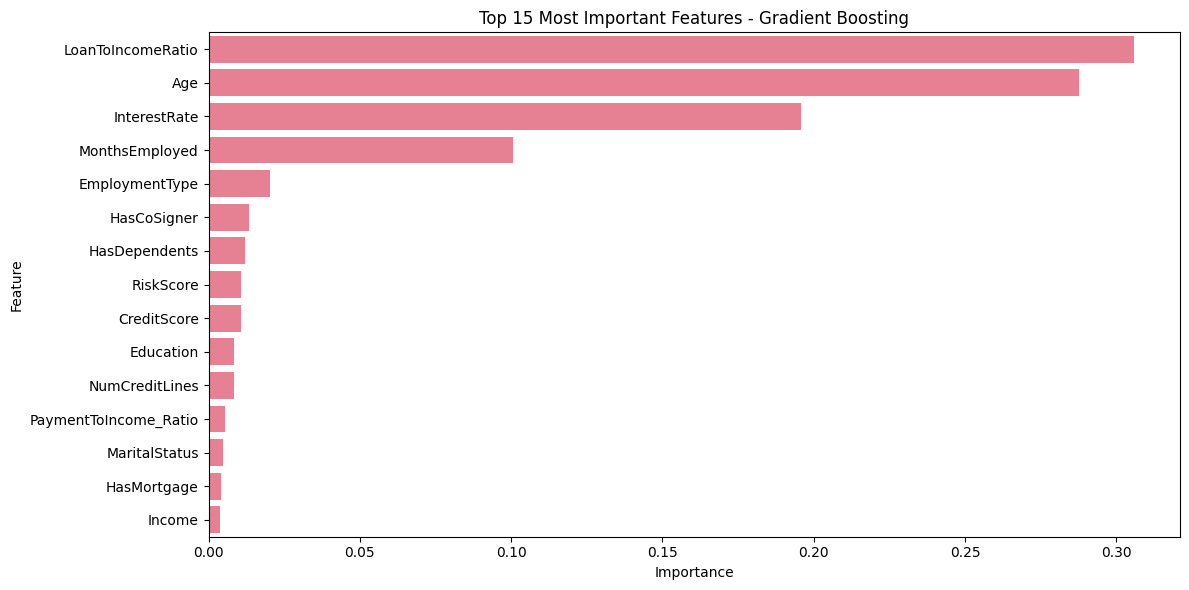

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

def custom_cross_val_score(model, X, y, cv):
    """
    Custom implementation of cross-validation scoring
    """
    cv_scores = []
    for train_idx, val_idx in cv.split(X, y):
        # Split data
        X_train_cv = X.iloc[train_idx] if isinstance(X, pd.DataFrame) else X[train_idx]
        X_val_cv = X.iloc[val_idx] if isinstance(X, pd.DataFrame) else X[val_idx]
        y_train_cv = y.iloc[train_idx] if isinstance(y, pd.Series) else y[train_idx]
        y_val_cv = y.iloc[val_idx] if isinstance(y, pd.Series) else y[val_idx]

        # Train model
        model_cv = GradientBoostingClassifier(**model.get_params())
        model_cv.fit(X_train_cv, y_train_cv)

        # Get predictions
        y_pred_proba = model_cv.predict_proba(X_val_cv)[:, 1]

        # Calculate ROC AUC
        cv_score = roc_auc_score(y_val_cv, y_pred_proba)
        cv_scores.append(cv_score)

    return np.array(cv_scores)

def evaluate_gradboost(X_train, X_test, y_train, y_test):
    """
    Evaluate Gradient Boosting model with comprehensive metrics and visualizations
    """
    gb_model = GradientBoostingClassifier(
        n_estimators=100,     # Number of boosting stages
        learning_rate=0.1,    # Learning rate shrinks the contribution of each tree
        max_depth=3,          # Max depth of individual trees
        min_samples_split=2,  # Min samples required to split internal node
        min_samples_leaf=1,   # Min samples required at leaf node
        subsample=0.8,        # Fraction of samples for fitting individual trees
        random_state=42
    )

    print("Training Gradient Boosting model...")
    gb_model.fit(X_train, y_train)

    y_pred = gb_model.predict(X_test)
    y_pred_proba = gb_model.predict_proba(X_test)[:, 1]

    gb_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba)
    }

    # Custom cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = custom_cross_val_score(gb_model, X_train, y_train, cv)

    print("\nGradient Boosting Model Performance:")
    for metric, value in gb_metrics.items():
        print(f"{metric}: {value:.4f}")
    print(f"\nCross-validation ROC AUC scores: {cv_scores}")
    print(f"Mean CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Gradient Boosting')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': gb_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Most Important Features - Gradient Boosting')
    plt.tight_layout()
    plt.show()

    return gb_model, gb_metrics, feature_importance

model, gb_metrics, feature_importance = evaluate_gradboost(X_train, X_test, y_train, y_test)

* Non-defaults (0.0):

> - Precision: 0.89 (89% of predicted non-defaults are actual non-defaults)
> - Recall: 0.99 (99% of actual non-defaults are correctly identified)
> - F1-score: 0.94 (excellent balance)


* Defaults (1.0):

> - Precision: 0.60 (60% of predicted defaults are actual defaults)
> - Recall: 0.06 (catches 6% of actual defaults)
> - F1-score: 0.11 (balance between precision and recall)

### LightGBM

Training LightGBM model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Model Performance:
Accuracy: 0.8864
Precision: 0.5976
Recall: 0.0676
F1 Score: 0.1215
ROC AUC: 0.7589

Cross-validation ROC AUC scores: [0.74835854 0.75525836 0.74751815 0.752434   0.75303229]
Mean CV ROC AUC: 0.7513 (+/- 0.0059)


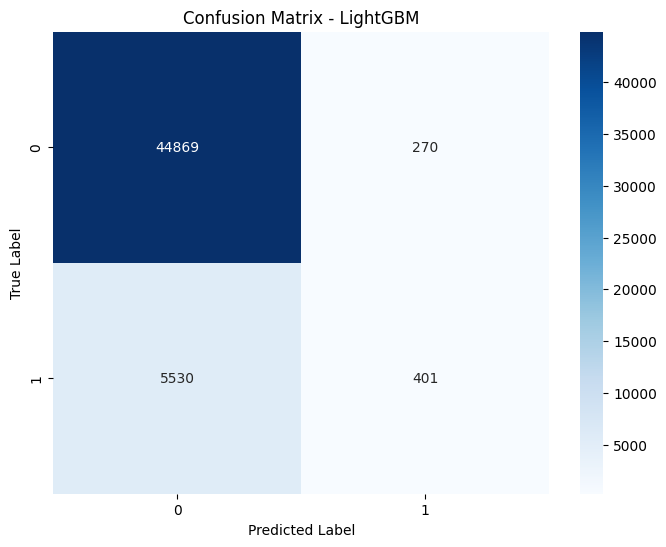


Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94     45139
         1.0       0.60      0.07      0.12      5931

    accuracy                           0.89     51070
   macro avg       0.74      0.53      0.53     51070
weighted avg       0.86      0.89      0.84     51070



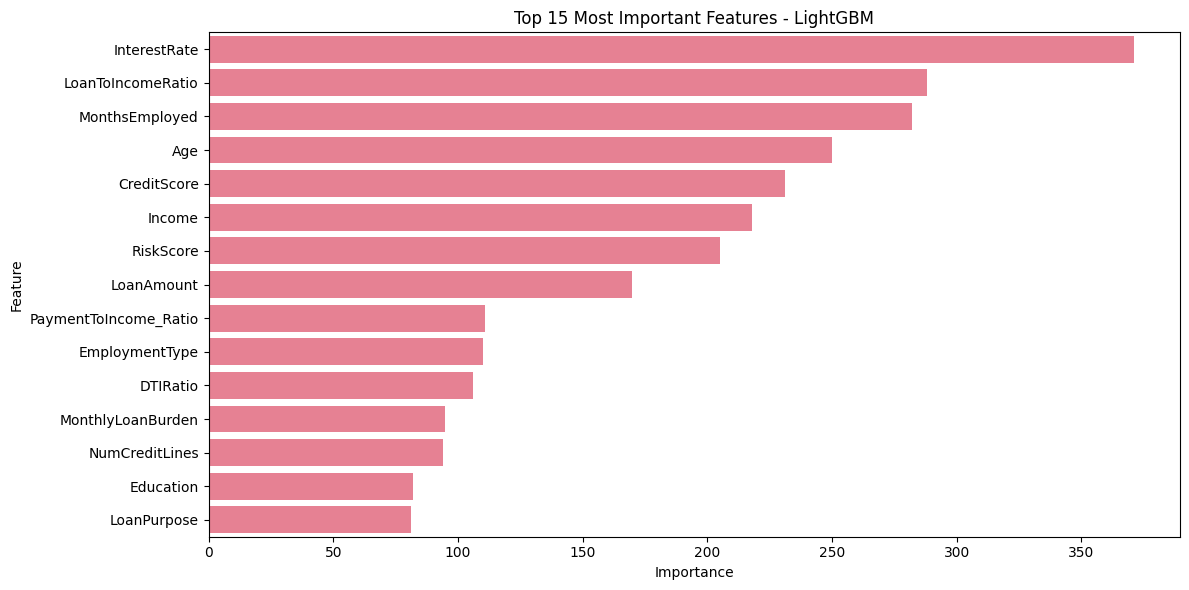


Top 10 Most Important Features:
                  Feature  Importance
6            InterestRate         371
16      LoanToIncomeRatio         288
4          MonthsEmployed         282
0                     Age         250
3             CreditScore         231
1                  Income         218
17              RiskScore         205
2              LoanAmount         170
19  PaymentToIncome_Ratio         111
10         EmploymentType         110


In [33]:
from lightgbm import LGBMClassifier

def custom_cross_val_score(model, X, y, cv):
    """
    Custom implementation of cross-validation scoring
    """
    cv_scores = []
    for train_idx, val_idx in cv.split(X, y):
        # Split data
        X_train_cv = X.iloc[train_idx] if isinstance(X, pd.DataFrame) else X[train_idx]
        X_val_cv = X.iloc[val_idx] if isinstance(X, pd.DataFrame) else X[val_idx]
        y_train_cv = y.iloc[train_idx] if isinstance(y, pd.Series) else y[train_idx]
        y_val_cv = y.iloc[val_idx] if isinstance(y, pd.Series) else y[val_idx]

        # Train model
        model_cv = LGBMClassifier(**model.get_params())
        model_cv.fit(X_train_cv, y_train_cv)

        # Get predictions
        y_pred_proba = model_cv.predict_proba(X_val_cv)[:, 1]

        # Calculate ROC AUC
        cv_score = roc_auc_score(y_val_cv, y_pred_proba)
        cv_scores.append(cv_score)

    return np.array(cv_scores)

def evaluate_lightgbm(X_train, X_test, y_train, y_test):
    """
    Evaluate LightGBM model with comprehensive metrics and visualizations
    """
    lgb_model = LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='binary',
        metric='auc',
        verbose=-1  # Suppress output
    )

    # Convert data to appropriate format if needed
    if isinstance(X_train, pd.DataFrame):
        X_train_arr = X_train.values
        X_test_arr = X_test.values
    else:
        X_train_arr = X_train
        X_test_arr = X_test

    if isinstance(y_train, pd.Series):
        y_train_arr = y_train.values
        y_test_arr = y_test.values
    else:
        y_train_arr = y_train
        y_test_arr = y_test

    print("Training LightGBM model...")
    lgb_model.fit(X_train_arr, y_train_arr)

    y_pred = lgb_model.predict(X_test_arr)
    y_pred_proba = lgb_model.predict_proba(X_test_arr)[:, 1]

    lgb_metrics = {
        'Accuracy': accuracy_score(y_test_arr, y_pred),
        'Precision': precision_score(y_test_arr, y_pred),
        'Recall': recall_score(y_test_arr, y_pred),
        'F1 Score': f1_score(y_test_arr, y_pred),
        'ROC AUC': roc_auc_score(y_test_arr, y_pred_proba)
    }

    # Custom cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = custom_cross_val_score(lgb_model, X_train, y_train, cv)

    print("\nLightGBM Model Performance:")
    for metric, value in lgb_metrics.items():
        print(f"{metric}: {value:.4f}")
    print(f"\nCross-validation ROC AUC scores: {cv_scores}")
    print(f"Mean CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test_arr, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - LightGBM')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test_arr, y_pred))

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns if isinstance(X_train, pd.DataFrame) else [f'F{i}' for i in range(X_train.shape[1])],
        'Importance': lgb_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot top 15 most important features
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Most Important Features - LightGBM')
    plt.tight_layout()
    plt.show()

    return lgb_model, lgb_metrics, feature_importance

model, lgb_metrics, feature_importance = evaluate_lightgbm(X_train, X_test, y_train, y_test)

* Non-defaults (0.0):

> - Precision: 0.89 (89% of predicted non-defaults are actual non-defaults)
> - Recall: 0.99 (99% of actual non-defaults are correctly identified)
> - F1-score: 0.94 (excellent balance)


* Defaults (1.0):

> - Precision: 0.60 (60% of predicted defaults are actual defaults)
> - Recall: 0.07 (catches 7% of actual defaults)
> - F1-score: 0.12 (balance between precision and recall)

### CatBoost

Training CatBoost model...

CatBoost Model Performance:
Accuracy: 0.8868
Precision: 0.6357
Recall: 0.0600
F1 Score: 0.1097
ROC AUC: 0.7603

Cross-validation ROC AUC scores: [0.75016727 0.75831805 0.74952694 0.75615184 0.75490973]
Mean CV ROC AUC: 0.7538 (+/- 0.0068)


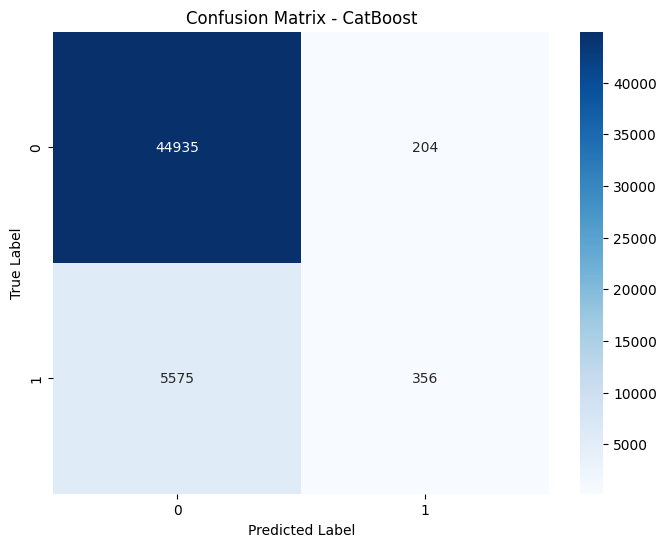


Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     45139
         1.0       0.64      0.06      0.11      5931

    accuracy                           0.89     51070
   macro avg       0.76      0.53      0.52     51070
weighted avg       0.86      0.89      0.84     51070



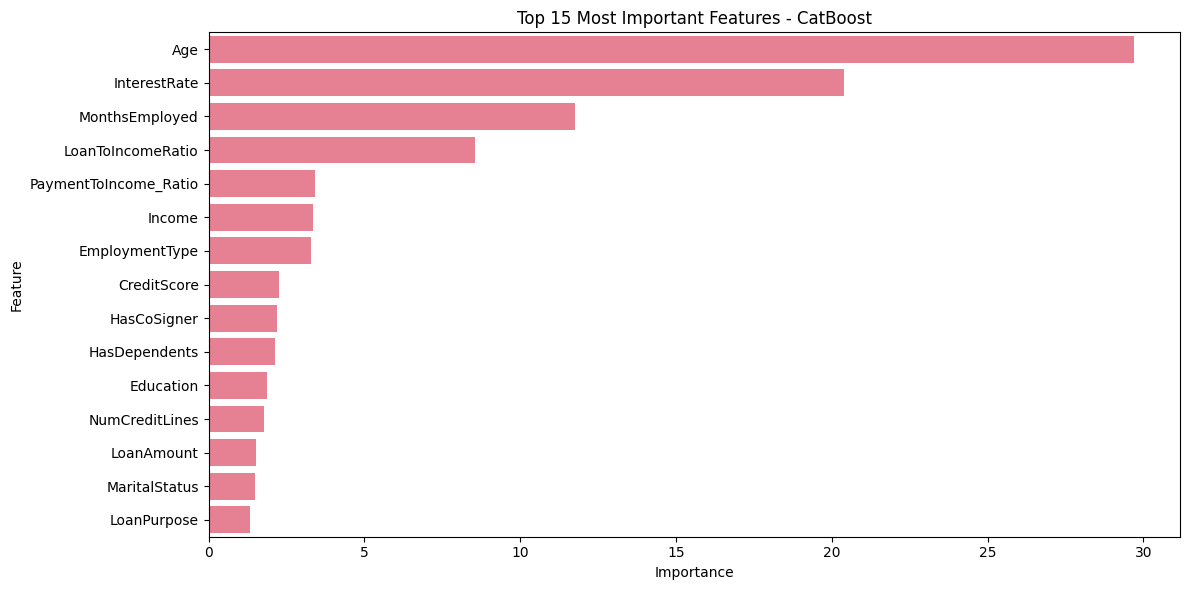

In [34]:
from catboost import CatBoostClassifier

def custom_cross_val_score(model, X, y, cv):
    """
    Custom implementation of cross-validation scoring
    """
    cv_scores = []
    for train_idx, val_idx in cv.split(X, y):
        # Split data
        X_train_cv = X.iloc[train_idx] if isinstance(X, pd.DataFrame) else X[train_idx]
        X_val_cv = X.iloc[val_idx] if isinstance(X, pd.DataFrame) else X[val_idx]
        y_train_cv = y.iloc[train_idx] if isinstance(y, pd.Series) else y[train_idx]
        y_val_cv = y.iloc[val_idx] if isinstance(y, pd.Series) else y[val_idx]

        # Train model
        model_cv = CatBoostClassifier(**{k: v for k, v in model.get_params().items()
                                       if k != 'cat_features'})
        model_cv.fit(X_train_cv, y_train_cv, silent=True)

        # Get predictions
        y_pred_proba = model_cv.predict_proba(X_val_cv)[:, 1]

        # Calculate ROC AUC
        cv_score = roc_auc_score(y_val_cv, y_pred_proba)
        cv_scores.append(cv_score)

    return np.array(cv_scores)

def evaluate_catboost(X_train, X_test, y_train, y_test):
    """
    Evaluate CatBoost model with comprehensive metrics and visualizations
    """
    catboost_model = CatBoostClassifier(
        iterations=100,       # Number of trees
        learning_rate=0.1,    # Learning rate
        depth=6,              # Depth of trees
        l2_leaf_reg=3,        # L2 regularization coefficient
        random_seed=42,
        verbose=False,        # Disable training output
        eval_metric='AUC'     # Metric to use for overfitting detection
    )

    print("Training CatBoost model...")
    catboost_model.fit(
        X_train, y_train,
        silent=True          # Disable logging
    )

    y_pred = catboost_model.predict(X_test)
    y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

    catboost_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = custom_cross_val_score(catboost_model, X_train, y_train, cv)

    print("\nCatBoost Model Performance:")
    for metric, value in catboost_metrics.items():
        print(f"{metric}: {value:.4f}")
    print(f"\nCross-validation ROC AUC scores: {cv_scores}")
    print(f"Mean CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - CatBoost')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': catboost_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Most Important Features - CatBoost')
    plt.tight_layout()
    plt.show()

    return catboost_model, catboost_metrics, feature_importance

model, catboost_metrics, feature_importance = evaluate_catboost(X_train, X_test, y_train, y_test)

* Non-defaults (0.0):

> - Precision: 0.89 (89% of predicted non-defaults are actual non-defaults)
> - Recall: 1.0 (100% of actual non-defaults are correctly identified)
> - F1-score: 0.94 (excellent balance)


* Defaults (1.0):

> - Precision: 0.64 (64% of predicted defaults are actual defaults)
> - Recall: 0.53 (catches 53% of actual defaults)
> - F1-score: 0.11 (balance between precision and recall)

### Decision Tree

Training Decision Tree model...

Decision Tree Model Performance:
Accuracy: 0.8104
Precision: 0.2024
Recall: 0.2151
F1 Score: 0.2086
ROC AUC: 0.5519

Cross-validation ROC AUC scores: [0.55052981 0.5552632  0.5465483  0.55064491 0.55873191]
Mean CV ROC AUC: 0.5523 (+/- 0.0084)


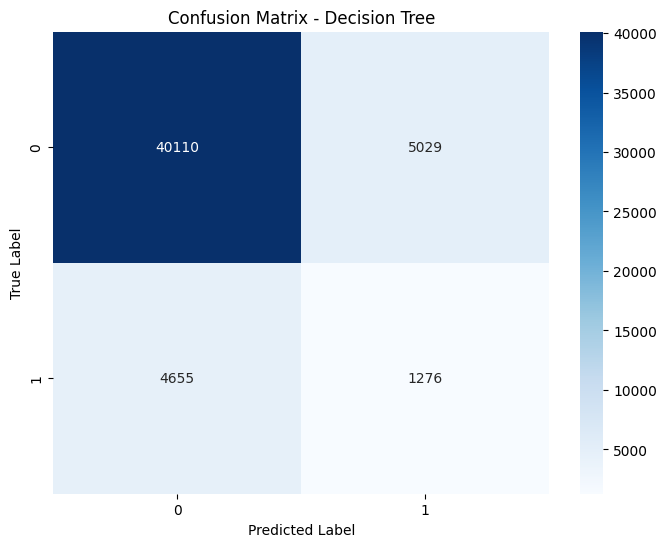


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     45139
         1.0       0.20      0.22      0.21      5931

    accuracy                           0.81     51070
   macro avg       0.55      0.55      0.55     51070
weighted avg       0.82      0.81      0.81     51070



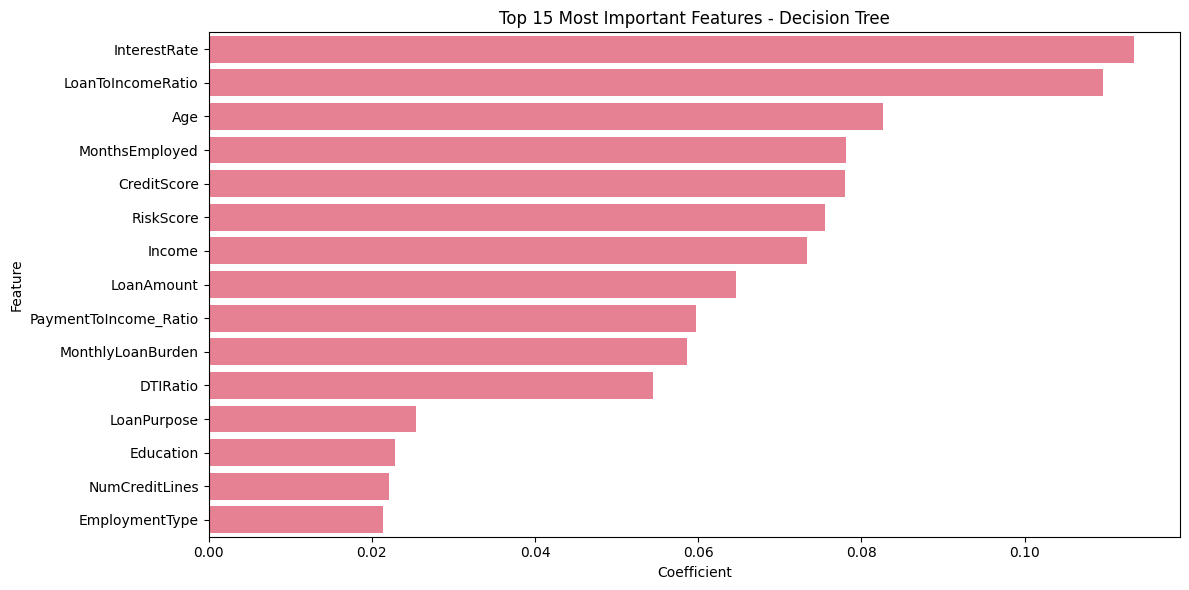

In [57]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='entropy', random_state=42)
model.fit(X_train, y_train)

def evaluate_decision_tree(X_train, X_test, y_train, y_test):
    """
    Evaluate Decision Tree model with comprehensive metrics and visualizations
    """
    dt_model = DecisionTreeClassifier(
        criterion='entropy',
        random_state=42)

    print("Training Decision Tree model...")
    dt_model.fit(X_train, y_train)

    y_pred = dt_model.predict(X_test)
    y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

    dt_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba)
    }

    cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='roc_auc')

    print("\nDecision Tree Model Performance:")
    for metric, value in dt_metrics.items():
        print(f"{metric}: {value:.4f}")
    print(f"\nCross-validation ROC AUC scores: {cv_scores}")
    print(f"Mean CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Decision Tree')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': dt_model.feature_importances_
    })
    feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Most Important Features - Decision Tree')
    plt.tight_layout()
    plt.show()

    return dt_model, dt_metrics, feature_importance

model, dt_metrics, feature_importance = evaluate_decision_tree(X_train, X_test, y_train, y_test)

## Model Performance Summary


Model Performance Comparison:
                     Accuracy  Precision  Recall  F1 Score  ROC AUC
CatBoost               0.8868     0.6357  0.0600    0.1097   0.7603
GradientBoosting       0.8863     0.6006  0.0629    0.1139   0.7590
LightGBM               0.8864     0.5976  0.0676    0.1215   0.7589
Logistic Regression    0.6881     0.2260  0.6950    0.3410   0.7589
XGBoost                0.8861     0.5824  0.0679    0.1217   0.7572
Random Forest          0.8850     0.5881  0.0315    0.0598   0.7331


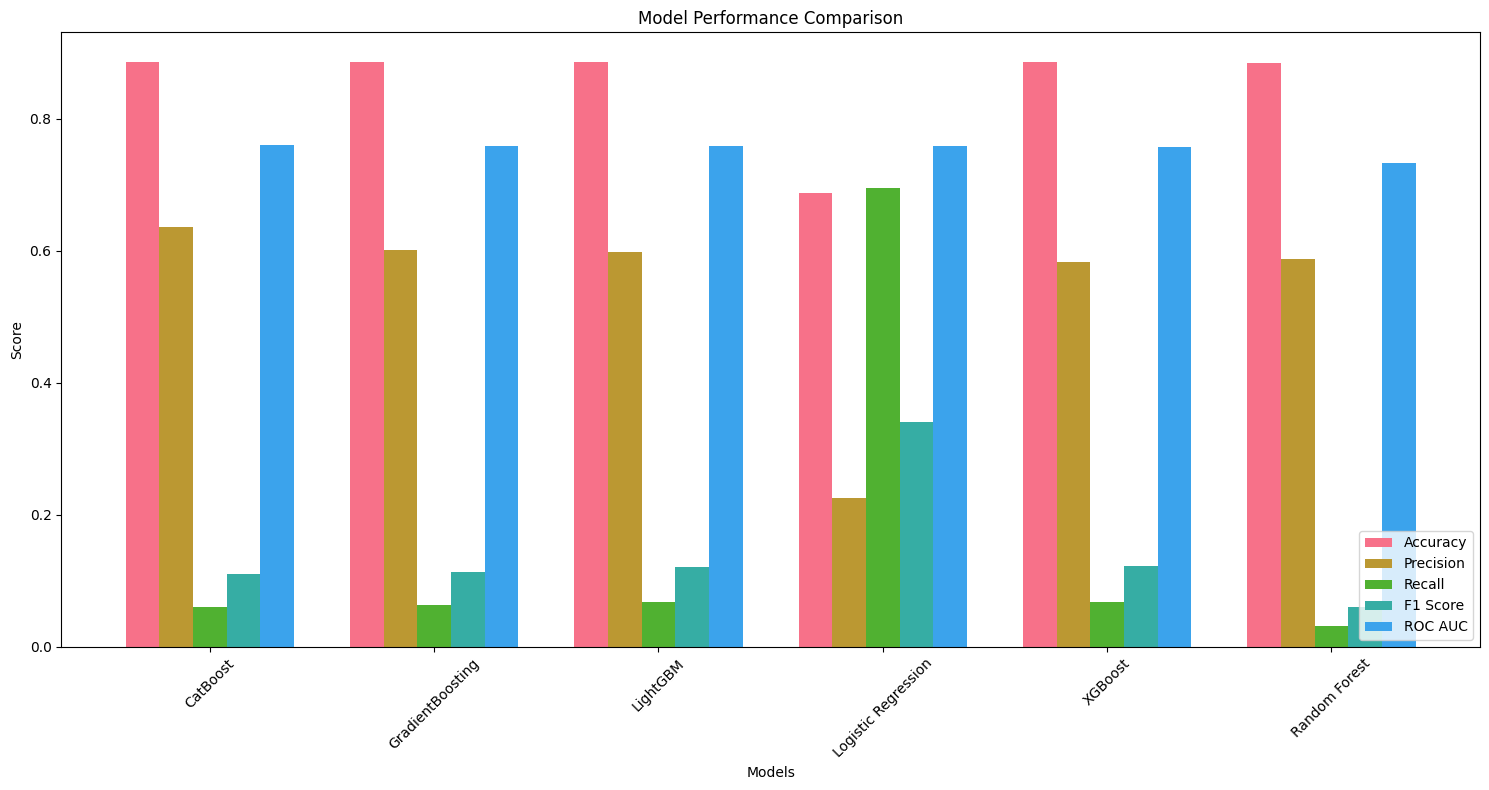


Best performing model based on ROC AUC: CatBoost


In [35]:
def compare_models(model_results):
    """
    Compare performance metrics across different models

    Parameters:
    model_results: dict
        Dictionary with model names as keys and their metrics as values
    """
    # Create comparison dataframe
    comparison_df = pd.DataFrame(model_results).T

    # Sort by ROC AUC score
    comparison_df = comparison_df.sort_values('ROC AUC', ascending=False)

    # Print tabular comparison
    print("\nModel Performance Comparison:")
    print(comparison_df.round(4))

    # Plot metrics comparison
    plt.figure(figsize=(15, 8))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

    x = np.arange(len(model_results))
    width = 0.15
    multiplier = 0

    for metric in metrics:
        offset = width * multiplier
        plt.bar(x + offset, comparison_df[metric], width, label=metric)
        multiplier += 1

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width * 2, comparison_df.index, rotation=45)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Return the best performing model based on ROC AUC
    best_model = comparison_df.index[0]
    print(f"\nBest performing model based on ROC AUC: {best_model}")
    return best_model

model_results = {
    'Logistic Regression': {
        'Accuracy': logistic_metrics['Accuracy'],
        'Precision': logistic_metrics['Precision'],
        'Recall': logistic_metrics['Recall'],
        'F1 Score': logistic_metrics['F1 Score'],
        'ROC AUC': logistic_metrics['ROC AUC']
    },
    'Random Forest': {
        'Accuracy': rf_metrics['Accuracy'],
        'Precision': rf_metrics['Precision'],
        'Recall': rf_metrics['Recall'],
        'F1 Score': rf_metrics['F1 Score'],
        'ROC AUC': rf_metrics['ROC AUC']
    },
    'XGBoost': {
        'Accuracy': xgb_metrics['Accuracy'],
        'Precision': xgb_metrics['Precision'],
        'Recall': xgb_metrics['Recall'],
        'F1 Score': xgb_metrics['F1 Score'],
        'ROC AUC': xgb_metrics['ROC AUC']
    },
    'LightGBM': {
        'Accuracy': lgb_metrics['Accuracy'],
        'Precision': lgb_metrics['Precision'],
        'Recall': lgb_metrics['Recall'],
        'F1 Score': lgb_metrics['F1 Score'],
        'ROC AUC': lgb_metrics['ROC AUC']
    },
    'GradientBoosting': {
        'Accuracy': gb_metrics['Accuracy'],
        'Precision': gb_metrics['Precision'],
        'Recall': gb_metrics['Recall'],
        'F1 Score': gb_metrics['F1 Score'],
        'ROC AUC': gb_metrics['ROC AUC']
    },
    'CatBoost': {
        'Accuracy': catboost_metrics['Accuracy'],
        'Precision': catboost_metrics['Precision'],
        'Recall': catboost_metrics['Recall'],
        'F1 Score': catboost_metrics['F1 Score'],
        'ROC AUC': catboost_metrics['ROC AUC']
    }
}

best_model = compare_models(model_results)

Based on Our summary, we see that tree -based models Have great accuracy and precision (correctly predicting which customers will default), they have horrible recall (too conservative, only correctly identifying 6%-7% of the data)

What We will try now is a two-stage approach, using Logistic Regression to act as a high-recall filter, to identify as many potential defaults as possible, and then using CatBoost to verify. This approach will hopefully cancel out the pros and cons of each model

## Two-Stage Approach

In [41]:

class TwoStageDefaultPredictor:
    def __init__(self, threshold_stage1=0.3):
        """
        Initialize the two-stage predictor.

        Parameters:
        threshold_stage1 (float): Threshold for stage 1 (Logistic Regression)
        """
        self.stage1_model = LogisticRegression()
        self.stage2_model = CatBoostClassifier(
            class_weights={0: 1, 1: 20},
            verbose=False)
        self.threshold_stage1 = threshold_stage1

    def fit(self, X_train, y_train):
        """
        Fit both models on the training data.
        """
        # Train stage 1 model (Logistic Regression)
        self.stage1_model.fit(X_train, y_train)

        # Get predictions from stage 1
        stage1_proba = self.stage1_model.predict_proba(X_train)[:, 1]
        potential_defaults = stage1_proba >= self.threshold_stage1

        # Train stage 2 model only on potential defaults from stage 1
        X_stage2 = X_train[potential_defaults]
        y_stage2 = y_train[potential_defaults]

        if len(X_stage2) > 0:
            self.stage2_model.fit(X_stage2, y_stage2)

        return self

    def predict(self, X):
        """
        Make predictions using both stages.
        """
        # Stage 1 predictions
        stage1_proba = self.stage1_model.predict_proba(X)[:, 1]
        potential_defaults = stage1_proba >= self.threshold_stage1

        # Initialize final predictions as all non-defaults
        final_predictions = np.zeros(len(X))

        # If stage 1 identified potential defaults
        if np.any(potential_defaults):
            # Get stage 2 predictions for potential defaults
            X_potential = X[potential_defaults]
            stage2_predictions = self.stage2_model.predict(X_potential)

            # Update final predictions where stage 2 confirms defaults
            final_predictions[potential_defaults] = stage2_predictions

        return final_predictions

    def evaluate(self, X_test, y_test):
        """
        Evaluate the two-stage model performance.
        """
        predictions = self.predict(X_test)

        metrics = {
            'precision': precision_score(y_test, predictions),
            'recall': recall_score(y_test, predictions),
            'f1': f1_score(y_test, predictions),
            'roc_auc': roc_auc_score(y_test, predictions)
        }

        return metrics

two_stage_model = TwoStageDefaultPredictor(threshold_stage1=0.2)
two_stage_model.fit(X_train, y_train)
metrics = two_stage_model.evaluate(X_test, y_test)
print("\nTwo-Stage Model Performance:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Two-Stage Model Performance:
precision: 0.3229
recall: 0.4429
f1: 0.3735
roc_auc: 0.6605
